<a href="https://colab.research.google.com/github/angelinemarym/Energy-Consumption-Prediction-London/blob/main/DataScience_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Energy Consumption Analysis and Prediction based on Weather Conditions and Household Groups in London using Random Forest Regression





## Import Libraries

In [ ]:
from google.colab import drive

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

## Load Datasets

### 1st Method: Mount datasets from Gdrive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
daily_energy_consumptions = pd.read_csv('/content/drive/MyDrive/DSDataset/daily_dataset.csv')
daily_energy_consumptions.head()

LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15         0.4850     0.432045       0.868   
1  MAC000131  2011-12-16         0.1415     0.296167       1.116   
2  MAC000131  2011-12-17         0.1015     0.189812       0.685   
3  MAC000131  2011-12-18         0.1140     0.218979       0.676   
4  MAC000131  2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066

In [ ]:
households = pd.read_csv('/content/drive/MyDrive/DSDataset/informations_households.csv')
households.head()

LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0

In [ ]:
weather = pd.read_csv('/content/drive/MyDrive/DSDataset/weather_daily_darksky.csv')
weather.head()

temperatureMax   temperatureMaxTime  windBearing                 icon  \
0           11.96  2011-11-11 23:00:00          123                  fog   
1            8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232                 wind   
4            8.22  2011-12-24 23:00:00          252  partly-cloudy-night   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   
4      2.79  2011-12-24 07:00:00        0.37       4.46   1028.17   

  apparentTemperatureMinTime  ...  temperatureHigh          sunriseTime  \
0        2011-11-11 07:00:00  ...            10.87  2011-11-11 07:12:14   
1        2011-12-11 02:00:00  ...             8.59  2011-12-11 07:57:02   
2        2011-12-27 22:00:00  ...            10.33  2011-12-27 08:07:06   
3        2011-12-02 07:00:00  ...             7.36  2011-12-02 07:46:09   
4        2011-12-24 07:00:00  ...             7.93  2011-12-24 08:06:15   

   temperatureHighTime          uvIndexTime  \
0  2011-11-11 19:00:00  2011-11-11 11:00:00   
1  2011-12-11 14:00:00  2011-12-11 12:00:00   
2  2011-12-27 14:00:00  2011-12-27 00:00:00   
3  2011-12-02 12:00:00  2011-12-02 10:00:00   
4  2011-12-24 15:00:00  2011-12-24 13:00:00   

                                             summary   temperatureLowTime  \
0                             Foggy until afternoon.  2011-11-11 19:00:00   
1                  Partly cloudy throughout the day.  2011-12-12 07:00:00   
2                  Mostly cloudy throughout the day.  2011-12-27 23:00:00   
3  Partly cloudy throughout the day and breezy ov...  2011-12-02 19:00:00   
4                  Mostly cloudy throughout the day.  2011-12-24 19:00:00   

   apparentTemperatureMin  apparentTemperatureMaxTime  \
0                    6.48         2011-11-11 23:00:00   
1                    0.11         2011-12-11 20:00:00   
2                    5.59         2011-12-27 02:00:00   
3                    0.46         2011-12-02 12:00:00   
4                   -0.51         2011-12-24 23:00:00   

  apparentTemperatureLowTime moonPhase  
0        2011-11-11 19:00:00      0.52  
1        2011-12-12 08:00:00      0.53  
2        2011-12-28 00:00:00      0.10  
3        2011-12-02 19:00:00      0.25  
4        2011-12-24 20:00:00      0.99  

[5 rows x 32 columns]

In [ ]:
holidays = pd.read_csv('/content/drive/MyDrive/DSDataset/uk_bank_holidays.csv')
holidays.head()

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)

### 2nd Method: Mount datasets directly from Kaggle

Prerequisites:
1.   Download Kaggle API token from Settings > Account menu. In the API section, click 'Create New Token'.
2.   Upload the 'kaggle.json' file to the root folder of your Gdrive.



In [ ]:
# 1. Install 'kaggle' library
! pip install kaggle

In [ ]:
# 2. Mount/connect colab to Gdrive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 3. Create a directory named '.kaggle' at the root folder of your Gdrive
! mkdir ~/.kaggle

In [ ]:
# 4. Copy the “kaggle.json” file from the mounted google drive to the current instance storage.
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# 5. Download the desired dataset: ! kaggle datasets download <name-of-dataset>
! kaggle datasets download jeanmidev/smart-meters-in-london

 98% 1.14G/1.17G [00:14<00:00, 68.5MB/s]
100% 1.17G/1.17G [00:14<00:00, 86.3MB/s]


In [ ]:
# 6. Unzip the downloaded file
! unzip smart-meters-in-london.zip

Archive:  smart-meters-in-london.zip
  inflating: acorn_details.csv       
  inflating: daily_dataset.csv       
  inflating: daily_dataset/daily_dataset/block_0.csv  
  inflating: daily_dataset/daily_dataset/block_1.csv  
  inflating: daily_dataset/daily_dataset/block_10.csv  
  inflating: daily_dataset/daily_dataset/block_100.csv  
  inflating: daily_dataset/daily_dataset/block_101.csv  
  inflating: daily_dataset/daily_dataset/block_102.csv  
  inflating: daily_dataset/daily_dataset/block_103.csv  
  inflating: daily_dataset/daily_dataset/block_104.csv  
  inflating: daily_dataset/daily_dataset/block_105.csv  
  inflating: daily_dataset/daily_dataset/block_106.csv  
  inflating: daily_dataset/daily_dataset/block_107.csv  
  inflating: daily_dataset/daily_dataset/block_108.csv  
  inflating: daily_dataset/daily_dataset/block_109.csv  
  inflating: daily_dataset/daily_dataset/block_11.csv  
  inflating: daily_dataset/daily_dataset/block_110.csv  
  inflating: daily_dataset/daily_datas

## Read the .csv file

### daily_dataset

In [ ]:
daily_energy_consumptions = pd.read_csv('daily_dataset.csv')
daily_energy_consumptions.head()

LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15         0.4850     0.432045       0.868   
1  MAC000131  2011-12-16         0.1415     0.296167       1.116   
2  MAC000131  2011-12-17         0.1015     0.189812       0.685   
3  MAC000131  2011-12-18         0.1140     0.218979       0.676   
4  MAC000131  2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066

In [ ]:
daily_energy_consumptions.dtypes

LCLid             object
day               object
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count       int64
energy_std       float64
energy_sum       float64
energy_min       float64
dtype: object

In [ ]:
daily_energy_consumptions.count()

LCLid            3510433
day              3510433
energy_median    3510403
energy_mean      3510403
energy_max       3510403
energy_count     3510433
energy_std       3499102
energy_sum       3510403
energy_min       3510403
dtype: int64

### informations_households

In [ ]:
households = pd.read_csv('informations_households.csv')
households.head()

LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0

In [ ]:
households.dtypes

LCLid            object
stdorToU         object
Acorn            object
Acorn_grouped    object
file             object
dtype: object

In [ ]:
households.count()

LCLid            5566
stdorToU         5566
Acorn            5566
Acorn_grouped    5566
file             5566
dtype: int64

### weather_daily_darksky

In [ ]:
weather = pd.read_csv('weather_daily_darksky.csv')
weather.head()

temperatureMax   temperatureMaxTime  windBearing                 icon  \
0           11.96  2011-11-11 23:00:00          123                  fog   
1            8.59  2011-12-11 14:00:00          198    partly-cloudy-day   
2           10.33  2011-12-27 02:00:00          225    partly-cloudy-day   
3            8.07  2011-12-02 23:00:00          232                 wind   
4            8.22  2011-12-24 23:00:00          252  partly-cloudy-night   

   dewPoint   temperatureMinTime  cloudCover  windSpeed  pressure  \
0      9.40  2011-11-11 07:00:00        0.79       3.88   1016.08   
1      4.49  2011-12-11 01:00:00        0.56       3.94   1007.71   
2      5.47  2011-12-27 23:00:00        0.85       3.54   1032.76   
3      3.69  2011-12-02 07:00:00        0.32       3.00   1012.12   
4      2.79  2011-12-24 07:00:00        0.37       4.46   1028.17   

  apparentTemperatureMinTime  ...  temperatureHigh          sunriseTime  \
0        2011-11-11 07:00:00  ...            10.87  2011-11-11 07:12:14   
1        2011-12-11 02:00:00  ...             8.59  2011-12-11 07:57:02   
2        2011-12-27 22:00:00  ...            10.33  2011-12-27 08:07:06   
3        2011-12-02 07:00:00  ...             7.36  2011-12-02 07:46:09   
4        2011-12-24 07:00:00  ...             7.93  2011-12-24 08:06:15   

   temperatureHighTime          uvIndexTime  \
0  2011-11-11 19:00:00  2011-11-11 11:00:00   
1  2011-12-11 14:00:00  2011-12-11 12:00:00   
2  2011-12-27 14:00:00  2011-12-27 00:00:00   
3  2011-12-02 12:00:00  2011-12-02 10:00:00   
4  2011-12-24 15:00:00  2011-12-24 13:00:00   

                                             summary   temperatureLowTime  \
0                             Foggy until afternoon.  2011-11-11 19:00:00   
1                  Partly cloudy throughout the day.  2011-12-12 07:00:00   
2                  Mostly cloudy throughout the day.  2011-12-27 23:00:00   
3  Partly cloudy throughout the day and breezy ov...  2011-12-02 19:00:00   
4                  Mostly cloudy throughout the day.  2011-12-24 19:00:00   

   apparentTemperatureMin  apparentTemperatureMaxTime  \
0                    6.48         2011-11-11 23:00:00   
1                    0.11         2011-12-11 20:00:00   
2                    5.59         2011-12-27 02:00:00   
3                    0.46         2011-12-02 12:00:00   
4                   -0.51         2011-12-24 23:00:00   

  apparentTemperatureLowTime moonPhase  
0        2011-11-11 19:00:00      0.52  
1        2011-12-12 08:00:00      0.53  
2        2011-12-28 00:00:00      0.10  
3        2011-12-02 19:00:00      0.25  
4        2011-12-24 20:00:00      0.99  

[5 rows x 32 columns]

In [ ]:
weather.dtypes

temperatureMax                 float64
temperatureMaxTime              object
windBearing                      int64
icon                            object
dewPoint                       float64
temperatureMinTime              object
cloudCover                     float64
windSpeed                      float64
pressure                       float64
apparentTemperatureMinTime      object
apparentTemperatureHigh        float64
precipType                      object
visibility                     float64
humidity                       float64
apparentTemperatureHighTime     object
apparentTemperatureLow         float64
apparentTemperatureMax         float64
uvIndex                        float64
time                            object
sunsetTime                      object
temperatureLow                 float64
temperatureMin                 float64
temperatureHigh                float64
sunriseTime                     object
temperatureHighTime             object
uvIndexTime              

In [ ]:
weather.count()

temperatureMax                 882
temperatureMaxTime             882
windBearing                    882
icon                           882
dewPoint                       882
temperatureMinTime             882
cloudCover                     881
windSpeed                      882
pressure                       882
apparentTemperatureMinTime     882
apparentTemperatureHigh        882
precipType                     882
visibility                     882
humidity                       882
apparentTemperatureHighTime    882
apparentTemperatureLow         882
apparentTemperatureMax         882
uvIndex                        881
time                           882
sunsetTime                     882
temperatureLow                 882
temperatureMin                 882
temperatureHigh                882
sunriseTime                    882
temperatureHighTime            882
uvIndexTime                    881
summary                        882
temperatureLowTime             882
apparentTemperatureM

In [ ]:
weather.describe()

temperatureMax  windBearing    dewPoint  cloudCover   windSpeed  \
count      882.000000   882.000000  882.000000  881.000000  882.000000   
mean        13.660113   195.702948    6.530034    0.477605    3.581803   
std          6.182744    89.340783    4.830875    0.193514    1.694007   
min         -0.060000     0.000000   -7.840000    0.000000    0.200000   
25%          9.502500   120.500000    3.180000    0.350000    2.370000   
50%         12.625000   219.000000    6.380000    0.470000    3.440000   
75%         17.920000   255.000000   10.057500    0.600000    4.577500   
max         32.400000   359.000000   17.770000    1.000000    9.960000   

          pressure  apparentTemperatureHigh  visibility    humidity  \
count   882.000000               882.000000  882.000000  882.000000   
mean   1014.127540                12.723866   11.167143    0.781871   
std      11.073038                 7.279168    2.466109    0.095348   
min     979.250000                -6.460000    1.480000    0.430000   
25%    1007.435000                 7.032500   10.327500    0.720000   
50%    1014.615000                12.470000   11.970000    0.790000   
75%    1021.755000                17.910000   12.830000    0.860000   
max    1040.920000                32.420000   15.340000    0.980000   

       apparentTemperatureLow  apparentTemperatureMax     uvIndex  \
count              882.000000              882.000000  881.000000   
mean                 6.085045               12.929467    2.542565   
std                  6.031967                7.105426    1.832985   
min                 -8.880000               -4.110000    0.000000   
25%                  1.522500                7.332500    1.000000   
50%                  5.315000               12.625000    2.000000   
75%                 11.467500               17.920000    4.000000   
max                 20.540000               32.420000    7.000000   

       temperatureLow  temperatureMin  temperatureHigh  \
count      882.000000      882.000000       882.000000   
mean         7.709841        7.414161        13.542392   
std          4.871004        4.888852         6.260196   
min         -5.640000       -5.640000        -0.810000   
25%          3.990000        3.705000         9.212500   
50%          7.540000        7.100000        12.470000   
75%         11.467500       11.277500        17.910000   
max         20.540000       20.540000        32.400000   

       apparentTemperatureMin   moonPhase  
count              882.000000  882.000000  
mean                 5.738039    0.500930  
std                  6.048746    0.287022  
min                 -8.880000    0.000000  
25%                  1.105000    0.260000  
50%                  4.885000    0.500000  
75%                 11.277500    0.750000  
max                 20.540000    0.990000

### holidays

In [ ]:
holidays = pd.read_csv('uk_bank_holidays.csv')
holidays.head()

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)

In [ ]:
holidays.dtypes

Bank holidays    object
Type             object
dtype: object

In [ ]:
holidays.count()

Bank holidays    25
Type             25
dtype: int64

In [ ]:
holidays.describe()

Bank holidays        Type
count             25          25
unique            25          11
top       2012-12-26  Boxing Day
freq               1           3

## 1. Data Preparation

### 1.1 'households' Dataframe

In [ ]:
# Remove 'Acorn' type that is not defined in 'acorn_details.csv'
households = households[households['Acorn'] != 'ACORN-']
households

LCLid stdorToU    Acorn Acorn_grouped       file
2     MAC000002      Std  ACORN-A      Affluent    block_0
3     MAC003613      Std  ACORN-A      Affluent    block_0
4     MAC003597      Std  ACORN-A      Affluent    block_0
5     MAC003579      Std  ACORN-A      Affluent    block_0
6     MAC003566      Std  ACORN-A      Affluent    block_0
...         ...      ...      ...           ...        ...
5561  MAC002056      Std  ACORN-U       ACORN-U  block_111
5562  MAC004587      Std  ACORN-U       ACORN-U  block_111
5563  MAC004828      Std  ACORN-U       ACORN-U  block_111
5564  MAC001704      ToU  ACORN-U       ACORN-U  block_111
5565  MAC002774      ToU  ACORN-U       ACORN-U  block_111

[5564 rows x 5 columns]

### 1.2 'daily_energy_consumptions' DataFrame

In [ ]:
#Checking for data outliers
daily_energy_consumptions.tail()

#check the date
print(daily_energy_consumptions[daily_energy_consumptions['day'] == '2014-02-28'])

#removing the entries where day = '2014-02-28'
daily_energy_consumptions = daily_energy_consumptions[daily_energy_consumptions['day'] != '2014-02-28']

             LCLid         day  energy_median  energy_mean  energy_max  \
806      MAC000131  2014-02-28          0.075        0.075       0.075   
1613     MAC000132  2014-02-28          0.049        0.049       0.049   
2434     MAC000221  2014-02-28          0.592        0.592       0.592   
3255     MAC000228  2014-02-28          0.039        0.039       0.039   
4076     MAC000234  2014-02-28          0.071        0.071       0.071   
...            ...         ...            ...          ...         ...   
3507356  MAC004926  2014-02-28          0.033        0.033       0.033   
3508127  MAC004932  2014-02-28          0.177        0.177       0.177   
3508898  MAC004937  2014-02-28          0.084        0.084       0.084   
3509666  MAC004965  2014-02-28          0.618        0.618       0.618   
3510432  MAC004977  2014-02-28          0.097        0.097       0.097   

         energy_count  energy_std  energy_sum  energy_min  
806                 1         NaN       0.075      

#### 1.2.1 Household count for different days

According the output, the number of households for which energy data was collected each day are diverse. It may happen because the adoption of smart meters in London is continuously increasing. This could lead to the incorrect perception that the energy for a specific day is high, when in reality the data was merely collected for a larger number of residences. We will check the house count on each day.

In [ ]:
housecount_per_day = daily_energy_consumptions.groupby('day')[['LCLid']].nunique()
housecount_per_day

LCLid
day              
2011-11-23     13
2011-11-24     25
2011-11-25     32
2011-11-26     41
2011-11-27     41
...           ...
2014-02-23   4998
2014-02-24   4994
2014-02-25   4995
2014-02-26   4993
2014-02-27   4990

[828 rows x 1 columns]

<Axes: xlabel='day'>

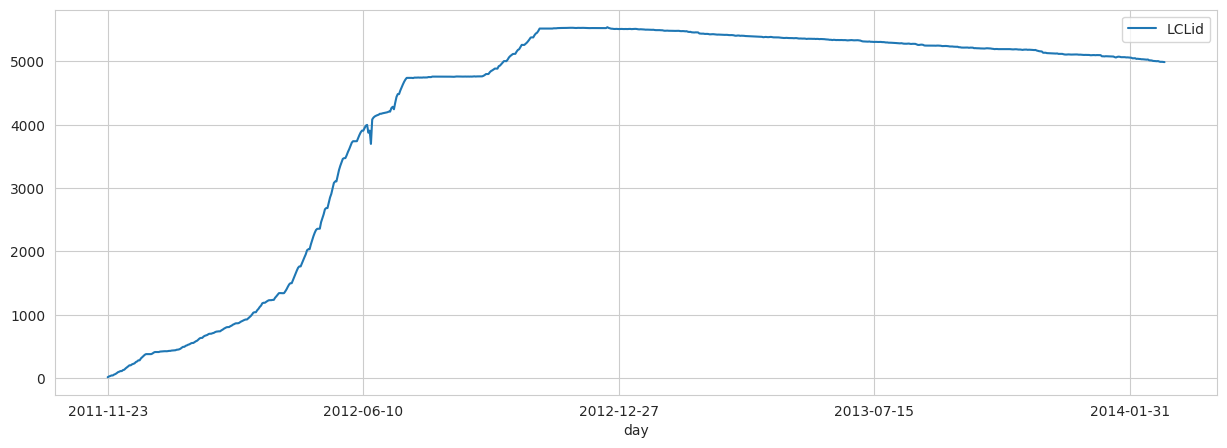

In [ ]:
housecount_per_day.plot(figsize=(15,5))

#### 1.2.2 Data Aggregation for Energy Consumed per Day across Households

Our focus is to predict energy consumption collectively, rather than to predict energy consumption for individual households. This decision is due to inconsistencies in data collection across households. Instead of analyzing energy usage per household, we'll consider *energy per household* as our target variable for prediction. This allows us to streamline the process since we're ultimately interested in forecasting overall energy consumption.

In [ ]:
# Sum up the total energy consumed by all households in each day
daily_energy_consumptions = daily_energy_consumptions.groupby('day')[['energy_sum']].sum()

# Merge 'housecount_per_day' Dataframe with 'daily_energy_consumptions' based on the 'day' property
daily_energy_consumptions = daily_energy_consumptions.merge(housecount_per_day, on = ['day'])

# Rename the merged column to 'household_num'
daily_energy_consumptions = daily_energy_consumptions.rename(columns={'LCLid': 'household_num'})

# Reset the index of the Dataframe 'daily_energy_consumptions'
daily_energy_consumptions = daily_energy_consumptions.reset_index()

In [ ]:
# Current number of data in the 'daily_energy_consumptions' Dataframe
daily_energy_consumptions.count()

day              828
energy_sum       828
household_num    828
dtype: int64

In [ ]:
# Convert the 'day' column to datetime format and extract only the date component from each datetime value.
daily_energy_consumptions.day = pd.to_datetime(daily_energy_consumptions.day, format='%Y-%m-%d').dt.date

In [ ]:
# Find the average energy consumed each day and create a new column
daily_energy_consumptions['avg_energy'] = daily_energy_consumptions['energy_sum']/daily_energy_consumptions['household_num']

In [ ]:
# Print the first and the last day in the dataset
print("Starting Point of Data at Day Level  :",min(daily_energy_consumptions.day))
print("Ending Point of Data at Day Level    :",max(daily_energy_consumptions.day))

Starting Point of Data at Day Level  : 2011-11-23
Ending Point of Data at Day Level    : 2014-02-27


In [ ]:
# Display the current view of 'daily_energy_consumptions' Dataframe
daily_energy_consumptions.head()

day  energy_sum  household_num  avg_energy
0  2011-11-23   90.385000             13    6.952692
1  2011-11-24  213.412000             25    8.536480
2  2011-11-25  303.993000             32    9.499781
3  2011-11-26  420.976000             41   10.267707
4  2011-11-27  444.883001             41   10.850805

In [ ]:
daily_energy_consumptions.describe()

energy_sum  household_num  avg_energy
count    828.000000     828.000000  828.000000
mean   42921.233141    4233.630435   10.370716
std    20100.840705    1790.885327    1.854013
min       90.385000      13.000000    6.952692
25%    34435.413751    4062.500000    8.566528
50%    45909.713997    5138.000000   10.376297
75%    58806.707502    5369.000000   11.832632
max    82650.492003    5541.000000   15.940238

### 1.3 'weather' Dataframe

#### 1.3.1 Add a 'day' column into the 'weather' dataframe in datetime format

In [ ]:
weather['day'] = pd.to_datetime(weather.time)
weather['day'] = pd.to_datetime(weather.day, format = '%Y%m%d').dt.date

In [ ]:
weather.dtypes

temperatureMax                 float64
temperatureMaxTime              object
windBearing                      int64
icon                            object
dewPoint                       float64
temperatureMinTime              object
cloudCover                     float64
windSpeed                      float64
pressure                       float64
apparentTemperatureMinTime      object
apparentTemperatureHigh        float64
precipType                      object
visibility                     float64
humidity                       float64
apparentTemperatureHighTime     object
apparentTemperatureLow         float64
apparentTemperatureMax         float64
uvIndex                        float64
time                            object
sunsetTime                      object
temperatureLow                 float64
temperatureMin                 float64
temperatureHigh                float64
sunriseTime                     object
temperatureHighTime             object
uvIndexTime              

#### 1.3.2 Feature Selection

In [ ]:
# Select numeric variables
weather = weather[['temperatureMax', 'windBearing', 'dewPoint', 'cloudCover', 'windSpeed',
       'pressure', 'apparentTemperatureHigh', 'visibility', 'humidity',
       'apparentTemperatureLow', 'apparentTemperatureMax', 'uvIndex',
       'temperatureLow', 'temperatureMin', 'temperatureHigh',
       'apparentTemperatureMin', 'moonPhase','day']]

In [ ]:
weather.dtypes

temperatureMax             float64
windBearing                  int64
dewPoint                   float64
cloudCover                 float64
windSpeed                  float64
pressure                   float64
apparentTemperatureHigh    float64
visibility                 float64
humidity                   float64
apparentTemperatureLow     float64
apparentTemperatureMax     float64
uvIndex                    float64
temperatureLow             float64
temperatureMin             float64
temperatureHigh            float64
apparentTemperatureMin     float64
moonPhase                  float64
day                         object
dtype: object

#### 1.3.3 Drop missing values

In [ ]:
weather.isna().sum()

temperatureMax             0
windBearing                0
dewPoint                   0
cloudCover                 1
windSpeed                  0
pressure                   0
apparentTemperatureHigh    0
visibility                 0
humidity                   0
apparentTemperatureLow     0
apparentTemperatureMax     0
uvIndex                    1
temperatureLow             0
temperatureMin             0
temperatureHigh            0
apparentTemperatureMin     0
moonPhase                  0
day                        0
dtype: int64

In [ ]:
weather = weather.dropna()

In [ ]:
weather.isna().any()

temperatureMax             False
windBearing                False
dewPoint                   False
cloudCover                 False
windSpeed                  False
pressure                   False
apparentTemperatureHigh    False
visibility                 False
humidity                   False
apparentTemperatureLow     False
apparentTemperatureMax     False
uvIndex                    False
temperatureLow             False
temperatureMin             False
temperatureHigh            False
apparentTemperatureMin     False
moonPhase                  False
day                        False
dtype: bool

### 1.4 'holidays' Dataframe

In [ ]:
holidays = holidays.rename(columns={'Bank holidays': 'day'})
holidays['holiday'] = 1
holidays.head()

day                                          Type  holiday
0  2012-12-26                                    Boxing Day        1
1  2012-12-25                                 Christmas Day        1
2  2012-08-27                           Summer bank holiday        1
3  2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)        1
4  2012-04-06          Spring bank holiday (substitute day)        1

In [ ]:
# Create a new 'day_without_year' column that stores the month and day of the holiday
holidays['day_without_year'] = pd.to_datetime(holidays.day).dt.strftime('%m-%d')
# holidays['day_without_year'] = pd.to_datetime(holidays.day_without_year, format = '%m-%d').dt.date

## 2. Data Exploration

### 2.1 Relationship of weather conditions with energy consumption

In [ ]:
# Merge 'weather' df with 'daily_energy_consumptions' df
weather_energy = daily_energy_consumptions.merge(weather, on = 'day')
weather_energy.head()

day  energy_sum  household_num  avg_energy  temperatureMax  \
0  2011-11-23   90.385000             13    6.952692           10.36   
1  2011-11-24  213.412000             25    8.536480           12.93   
2  2011-11-25  303.993000             32    9.499781           13.03   
3  2011-11-26  420.976000             41   10.267707           12.96   
4  2011-11-27  444.883001             41   10.850805           13.54   

   windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
0          229      6.29        0.36       2.04   1027.12  ...        8.06   
1          204      8.56        0.41       4.04   1027.22  ...       10.64   
2          243      7.24        0.48       5.02   1024.47  ...       12.38   
3          237      6.96        0.44       5.75   1025.80  ...       13.07   
4          256      5.76        0.42       5.48   1021.11  ...       13.08   

   humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
0      0.93                    6.56                   10.36      1.0   
1      0.89                    7.30                   12.93      1.0   
2      0.79                    4.69                   13.03      1.0   
3      0.81                   11.59                   12.96      1.0   
4      0.72                    1.31                   13.54      1.0   

   temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            8.24            3.81            10.36                    2.18   
1            9.71            8.56            12.93                    7.01   
2            7.01            7.46            12.27                    4.84   
3           11.59            7.01            12.96                    4.69   
4            1.31            4.47            13.54                    2.94   

   moonPhase  
0       0.94  
1       0.97  
2       0.01  
3       0.05  
4       0.08  

[5 rows x 21 columns]

In [ ]:
weather_energy.tail()

day    energy_sum  household_num  avg_energy  temperatureMax  \
822  2014-02-23  57379.092995           4998   11.480411           11.94   
823  2014-02-24  51994.547004           4994   10.411403           14.23   
824  2014-02-25  51423.508001           4995   10.294997           11.43   
825  2014-02-26  50943.305995           4993   10.202945           11.29   
826  2014-02-27  51678.185998           4990   10.356350           10.31   

     windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  visibility  \
822          200      6.17        0.66       7.10   1010.37  ...       12.33   
823          183      6.03        0.50       5.02   1005.19  ...       13.00   
824          202      5.06        0.62       5.69   1000.65  ...       12.09   
825          227      2.74        0.26       3.82   1012.73  ...       13.00   
826          224      3.08        0.32       4.14   1007.02  ...       12.04   

     humidity  apparentTemperatureLow  apparentTemperatureMax  uvIndex  \
822      0.76                    5.52                   11.94      1.0   
823      0.74                    4.78                   14.23      1.0   
824      0.78                    1.67                   11.43      1.0   
825      0.73                    3.03                   11.29      2.0   
826      0.74                    0.82                   10.31      2.0   

     temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
822            7.99            8.67            11.94                    5.53   
823            8.25            7.99            14.23                    5.52   
824            4.17            6.79            10.31                    3.89   
825            6.01            4.17            11.29                    1.67   
826            3.43            3.93            10.31                    1.41   

     moonPhase  
822       0.78  
823       0.82  
824       0.86  
825       0.90  
826       0.93  

[5 rows x 21 columns]

#### 2.1.1 Temperature

The plot shows that there is an inverse correlation between energy consumption and temperature. Peaks in energy consumption correspond to troughs in temperature, and vice versa. This supports the common understanding that colder temperatures lead to higher energy usage, likely due to increased use of heating systems and similar devices.

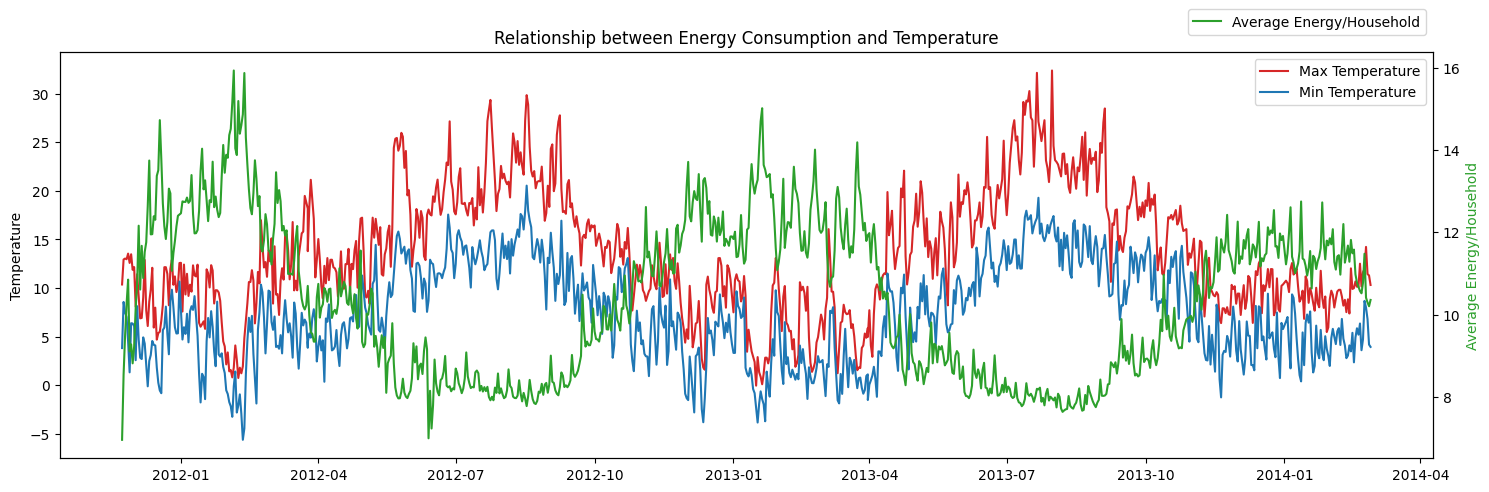

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(weather_energy.day, weather_energy.temperatureMax, color='tab:red', label='Max Temperature')
ax1.plot(weather_energy.day, weather_energy.temperatureMin, color='tab:blue', label='Min Temperature')
ax1.set_ylabel('Temperature')
ax1.legend()

ax2 = ax1.twinx()
ax2.plot(weather_energy.day, weather_energy.avg_energy, color='tab:green', label='Average Energy/Household')
ax2.set_ylabel('Average Energy/Household', color='tab:green')
ax2.legend(bbox_to_anchor=(0.0, 1.02, 1.0, 0.102))

plt.title('Relationship between Energy Consumption and Temperature')
fig.tight_layout()
plt.show()

#### 2.1.2 Humidity

The observation shows that humidity and average energy usage appear to follow a similar trend.

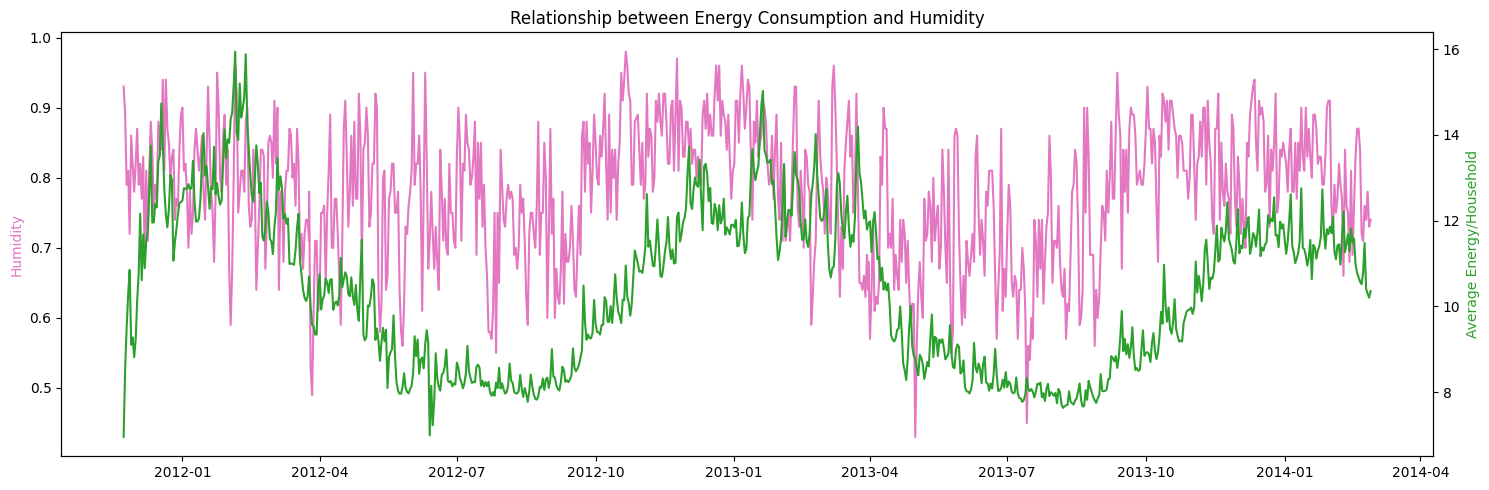

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.humidity, color = 'tab:pink')
ax1.set_ylabel('Humidity',color = 'tab:pink')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Relationship between Energy Consumption and Humidity')

fig.tight_layout()
plt.show()

#### 2.1.3 Cloud Cover

The observation shows that cloud cover and average energy usage appear to follow a similar trend.

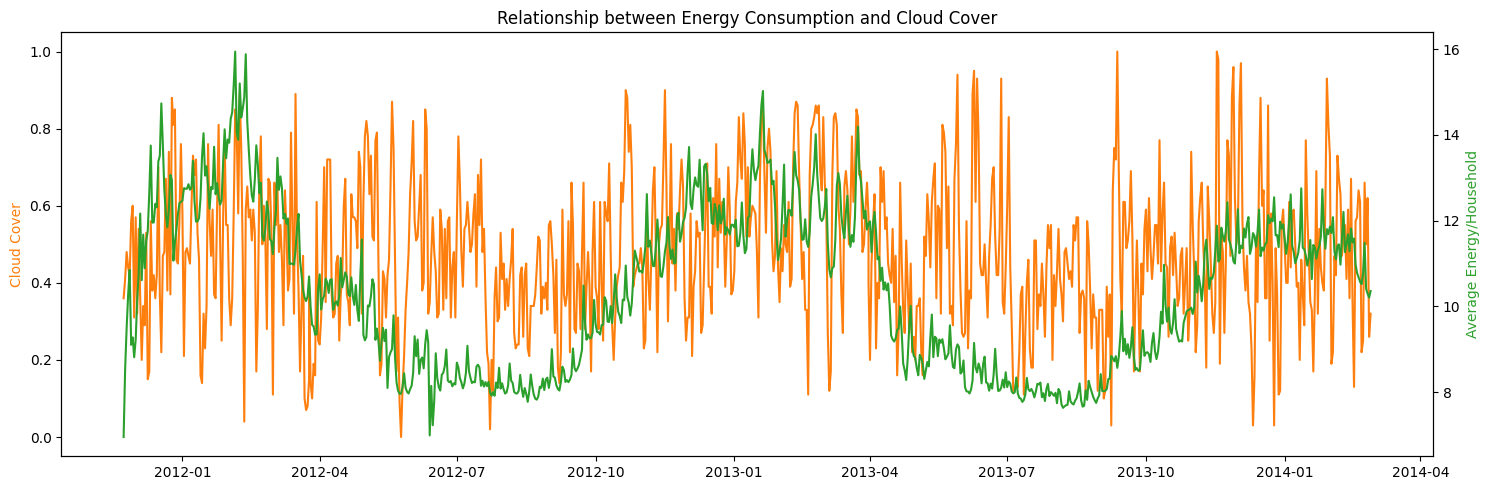

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.cloudCover, color = 'tab:orange')
ax1.set_ylabel('Cloud Cover',color = 'tab:orange')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Relationship between Energy Consumption and Cloud Cover')

fig.tight_layout()
plt.show()

#### 2.1.4 Visibility

The visibility component appears to have little effect on energy consumption; because visibility is most likely an outdoor element, its rise or decrease is unlikely to affect energy consumption within a household.

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.visibility, color = 'tab:purple')
ax1.set_ylabel('Visibility',color = 'tab:purple')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Relationship between Energy Consumption and Visibility')

fig.tight_layout()
plt.show()

#### 2.1.5 Wind Speed

Wind speed, like visibility, appears to be an external characteristic that has no direct effect on energy use.

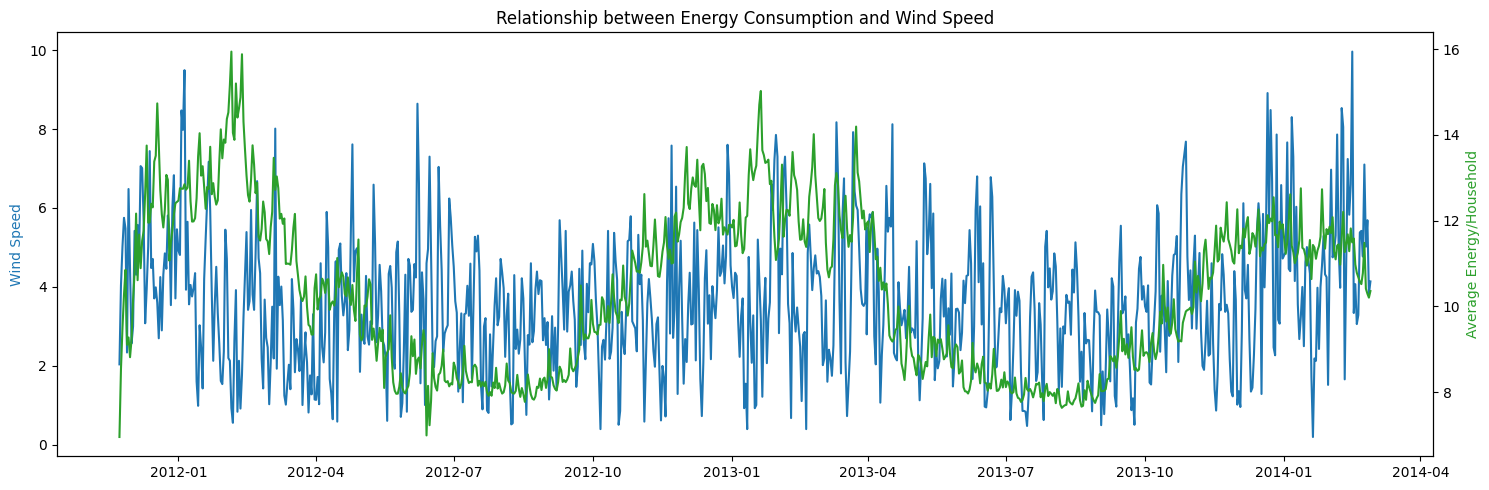

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.windSpeed, color = 'tab:blue')
ax1.set_ylabel('Wind Speed',color = 'tab:blue')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')

plt.title('Relationship between Energy Consumption and Wind Speed')
fig.tight_layout()
plt.show()

#### 2.1.6 UV Index

The UV index has an inverse relationship with energy consumption. This may be influenced by brighter and sunnier conditions, resulting in less energy consumption for lightning. High UV index often corresponds to warmer temperatures. Warmer weather leads to decreased energy consumption for heating systems.

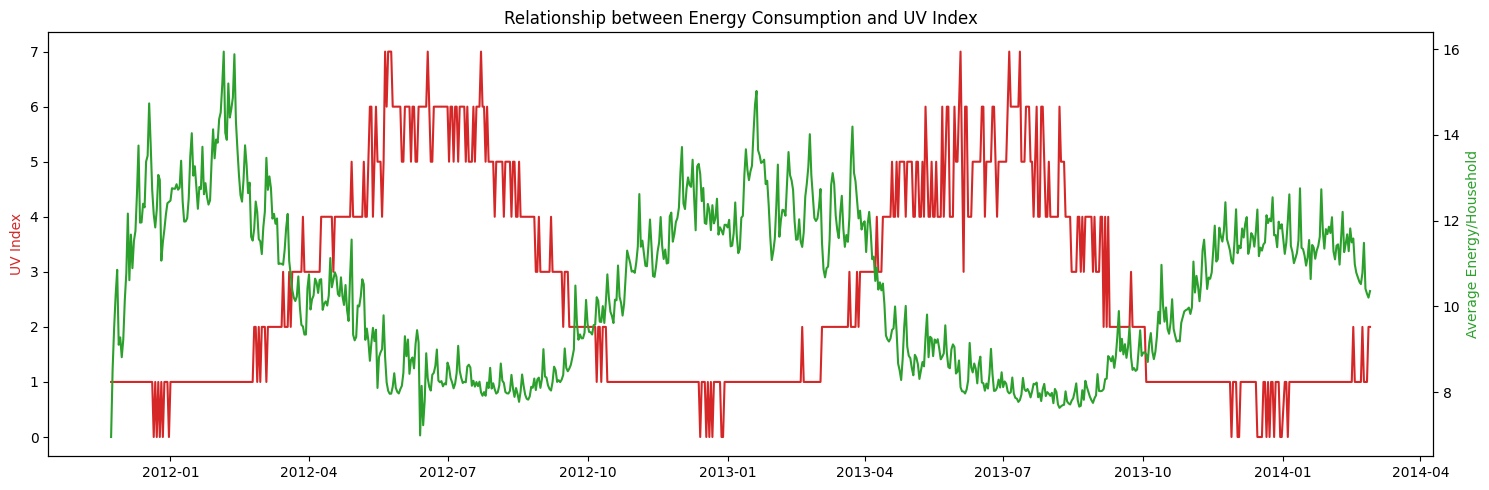

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.uvIndex, color = 'tab:red')
ax1.set_ylabel('UV Index',color = 'tab:red')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')
plt.title('Relationship between Energy Consumption and UV Index')

fig.tight_layout()
plt.show()

#### 2.1.7 Dew Point

Dew Point is a function of humidity and temperature, hence it has a comparable relationship to energy usage.

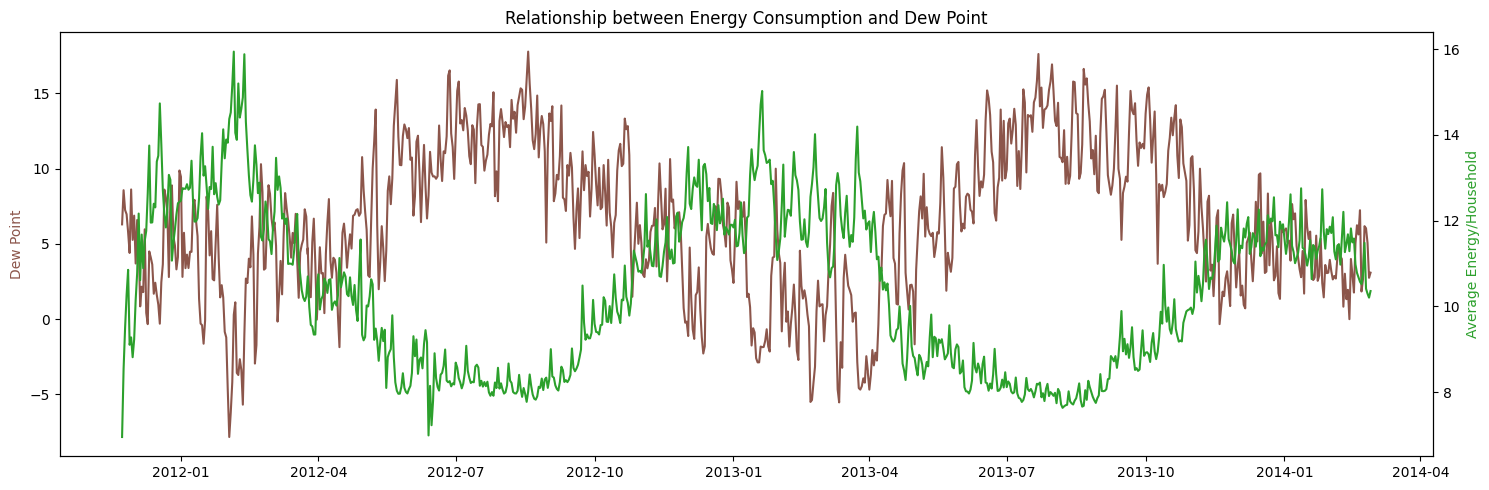

In [ ]:
fig, ax1 = plt.subplots(figsize = (15,5))
ax1.plot(weather_energy.day, weather_energy.dewPoint, color = 'tab:brown')
ax1.set_ylabel('Dew Point',color = 'tab:brown')

ax2 = ax1.twinx()
ax2.plot(weather_energy.day,weather_energy.avg_energy,color = 'tab:green')
ax2.set_ylabel('Average Energy/Household',color = 'tab:green')

plt.title('Relationship between Energy Consumption and Dew Point')
fig.tight_layout()
plt.show()

### 2.2 Relationship of changes of season and holidays with energy consumption

In [ ]:
# Extract the month
weather_energy['day'] = pd.to_datetime(weather_energy['day'])
weather_energy['month'] = weather_energy['day'].dt.month
weather_energy

day    energy_sum  household_num  avg_energy  temperatureMax  \
0   2011-11-23     90.385000             13    6.952692           10.36   
1   2011-11-24    213.412000             25    8.536480           12.93   
2   2011-11-25    303.993000             32    9.499781           13.03   
3   2011-11-26    420.976000             41   10.267707           12.96   
4   2011-11-27    444.883001             41   10.850805           13.54   
..         ...           ...            ...         ...             ...   
822 2014-02-23  57379.092995           4998   11.480411           11.94   
823 2014-02-24  51994.547004           4994   10.411403           14.23   
824 2014-02-25  51423.508001           4995   10.294997           11.43   
825 2014-02-26  50943.305995           4993   10.202945           11.29   
826 2014-02-27  51678.185998           4990   10.356350           10.31   

     windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  humidity  \
0            229      6.29        0.36       2.04   1027.12  ...      0.93   
1            204      8.56        0.41       4.04   1027.22  ...      0.89   
2            243      7.24        0.48       5.02   1024.47  ...      0.79   
3            237      6.96        0.44       5.75   1025.80  ...      0.81   
4            256      5.76        0.42       5.48   1021.11  ...      0.72   
..           ...       ...         ...        ...       ...  ...       ...   
822          200      6.17        0.66       7.10   1010.37  ...      0.76   
823          183      6.03        0.50       5.02   1005.19  ...      0.74   
824          202      5.06        0.62       5.69   1000.65  ...      0.78   
825          227      2.74        0.26       3.82   1012.73  ...      0.73   
826          224      3.08        0.32       4.14   1007.02  ...      0.74   

     apparentTemperatureLow  apparentTemperatureMax  uvIndex  temperatureLow  \
0                      6.56                   10.36      1.0            8.24   
1                      7.30                   12.93      1.0            9.71   
2                      4.69                   13.03      1.0            7.01   
3                     11.59                   12.96      1.0           11.59   
4                      1.31                   13.54      1.0            1.31   
..                      ...                     ...      ...             ...   
822                    5.52                   11.94      1.0            7.99   
823                    4.78                   14.23      1.0            8.25   
824                    1.67                   11.43      1.0            4.17   
825                    3.03                   11.29      2.0            6.01   
826                    0.82                   10.31      2.0            3.43   

     temperatureMin  temperatureHigh  apparentTemperatureMin  moonPhase  month  
0              3.81            10.36                    2.18       0.94     11  
1              8.56            12.93                    7.01       0.97     11  
2              7.46            12.27                    4.84       0.01     11  
3              7.01            12.96                    4.69       0.05     11  
4              4.47            13.54                    2.94       0.08     11  
..              ...              ...                     ...        ...    ...  
822            8.67            11.94                    5.53       0.78      2  
823            7.99            14.23                    5.52       0.82      2  
824            6.79            10.31                    3.89       0.86      2  
825            4.17            11.29                    1.67       0.90      2  
826            3.93            10.31                    1.41       0.93      2  

[827 rows x 22 columns]

In [ ]:
# Create a new 'day_without_year' column that stores the month and day of the holiday
weather_energy['day_without_year'] = pd.to_datetime(weather_energy.day).dt.strftime('%m-%d')

In [ ]:
# Merge weather_energy df with holidays
weather_energy_holiday = weather_energy.merge(holidays, on = 'day_without_year')
weather_energy_holiday = weather_energy_holiday.drop_duplicates(subset=['day_x'])
weather_energy_holiday.head()

day_x    energy_sum  household_num  avg_energy  temperatureMax  \
0  2011-12-25   4894.883999            378   12.949429           11.98   
3  2012-12-25  68988.858001           5515   12.509312            9.14   
6  2013-12-25  64006.147991           5103   12.542847            7.19   
9  2011-12-26   4182.788001            378   11.065577           12.91   
12 2012-12-26  64350.884999           5513   11.672571           10.18   

    windBearing  dewPoint  cloudCover  windSpeed  pressure  ...  \
0           237      7.90        0.88       5.81   1028.45  ...   
3           225      6.27        0.56       4.39    995.66  ...   
6           194      2.57        0.03       2.47    984.66  ...   
9           236      8.88        0.81       5.44   1033.14  ...   
12          230      5.73        0.39       5.05   1004.15  ...   

    temperatureLow  temperatureMin  temperatureHigh  apparentTemperatureMin  \
0            11.52            8.67            11.54                    5.93   
3             4.83            6.46             9.14                    3.86   
6             2.87            3.74             7.19                    0.23   
9             9.79            9.82            12.91                    6.91   
12            6.42            4.83            10.18                    1.34   

    moonPhase  month  day_without_year       day_y           Type  holiday  
0        0.03     12             12-25  2012-12-25  Christmas Day        1  
3        0.41     12             12-25  2012-12-25  Christmas Day        1  
6        0.75     12             12-25  2012-12-25  Christmas Day        1  
9        0.07     12             12-26  2012-12-26     Boxing Day        1  
12       0.44     12             12-26  2012-12-26     Boxing Day        1  

[5 rows x 26 columns]

In [ ]:
# Split 'weather_energy' data into four seasons
spring = weather_energy[(weather_energy['month'] >= 3) & (weather_energy['month'] <= 5)]
summer = weather_energy[(weather_energy['month'] >= 6) & (weather_energy['month'] <= 8)]
autumn = weather_energy[(weather_energy['month'] >= 9) & (weather_energy['month'] <= 11)]
winter = weather_energy[(weather_energy['month'] == 12) | (weather_energy['month'] <= 2)]

The output shows that people consume electricity the most in winter due to high usage of heaters. Meanwhile, the least energy consumption is in summer because the weather is warmer. In addition, the dots marked the power usage during holidays. It seems that we cannot conclude the electricity consumption pattern based on the holidays because its randomness. It happened because people may go out for holidays or each holiday can have different approach to enjoy (either enjoy the holiday at home or have a trip)

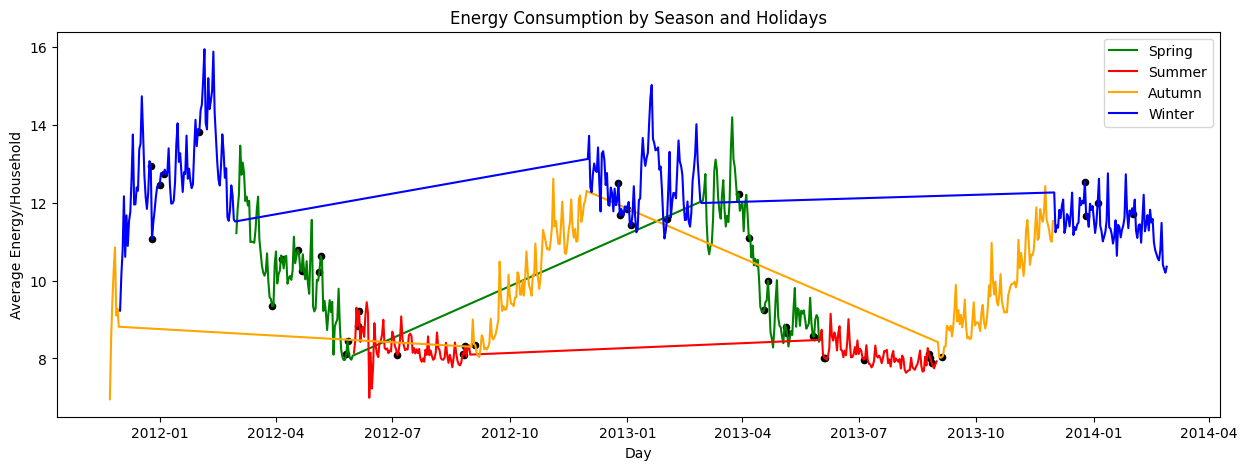

In [ ]:
# Plot each season with different colors
fig, ax = plt.subplots(figsize=(15, 5))

# Plot spring
ax.plot(spring['day'], spring['avg_energy'], color='green', label='Spring')

# Plot summer
ax.plot(summer['day'], summer['avg_energy'], color='red', label='Summer')

# Plot autumn
ax.plot(autumn['day'], autumn['avg_energy'], color='orange', label='Autumn')

# Plot winter
ax.plot(winter['day'], winter['avg_energy'], color='blue', label='Winter')

plt.scatter(weather_energy_holiday['day_x'], weather_energy_holiday['avg_energy'],marker = 'o', s = 20, color = 'black', zorder=1)

# Set labels and title
ax.set_ylabel('Average Energy/Household')
ax.set_xlabel('Day')
ax.set_title('Energy Consumption by Season and Holidays')
ax.legend()

plt.show()

### 2.2 Correlation between Weather Variables and Energy Consumption

The relationship between weather variables and energy consumption reveals that **humidity** is positively correlated with energy, whereas **temperature** exhibits a negative correlation. Factors like dew point and UV index show multicollinearity with temperature, so they were excluded from the analysis. Similarly, cloud cover and visibility were discarded due to multicollinearity with humidity. Pressure and moon phase showed minimal correlation with energy and were therefore disregarded. **Wind speed**, while having a low correlation with energy, did not exhibit multicollinearity and was retained for further analysis.

Text(0.5, 1.0, 'Correlation between Weather Variables and Energy Consumption')

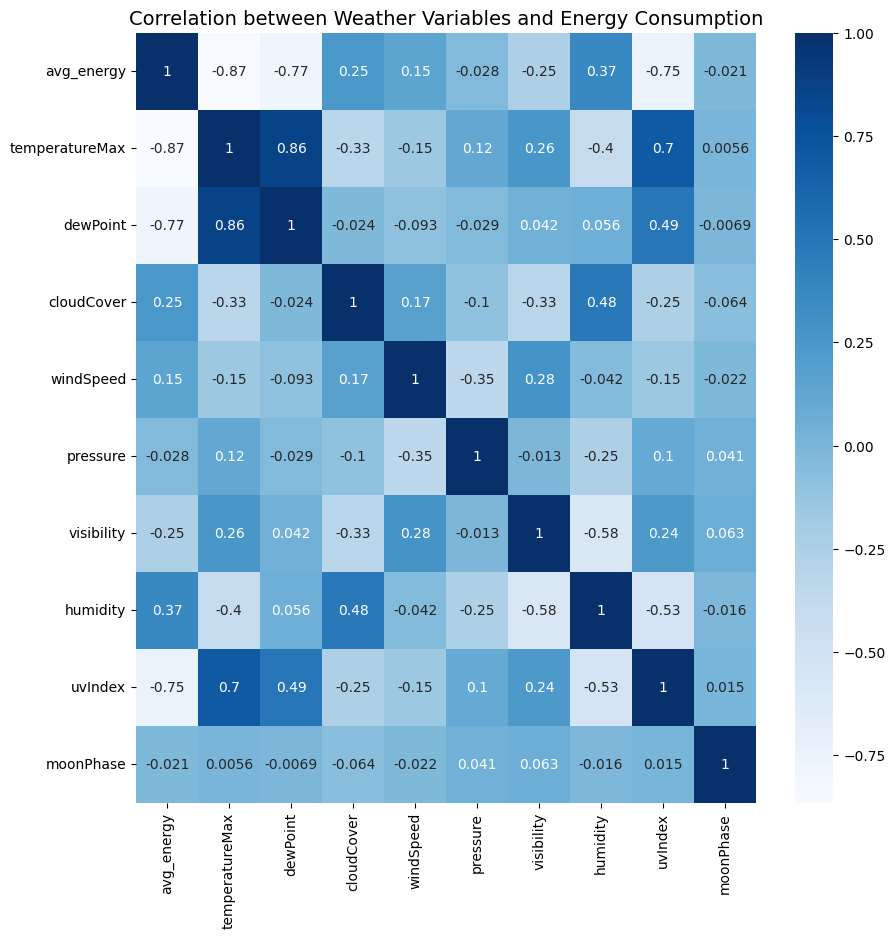

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
corr_matrix = weather_energy[['avg_energy','temperatureMax','dewPoint', 'cloudCover', 'windSpeed','pressure', 'visibility', 'humidity','uvIndex', 'moonPhase']].corr()
sns.heatmap(corr_matrix, cmap = 'Blues', annot = True)
plt.title('Correlation between Weather Variables and Energy Consumption', fontsize = 14)

### 2.3 Daily Electrical Consumption in Greater London

#### 2.3.1 Exploring relationship between Acorn category and daily energy usage

In [ ]:
# filtering ACORN-U from households -> because data about ACORN-U is not available
households_f = households[households['Acorn'] != 'ACORN-U']

#loading an unedited daily_energy_consumptions
daily_energy_consumptions2 = pd.read_csv('daily_dataset.csv')
daily_energy_consumptions2 = daily_energy_consumptions2[daily_energy_consumptions2['day'] != '2014-02-28']

# Appending the Acorn of each household onto daily energy_consumptions
daily_energy_consumptions_with_acorn = pd.merge(daily_energy_consumptions2, households_f[['LCLid', 'Acorn']], on='LCLid', how='left')
daily_energy_consumptions_with_acorn.tail()

LCLid         day  energy_median  energy_mean  energy_max  \
3505441  MAC004977  2014-02-23         0.1365     0.174646       0.754   
3505442  MAC004977  2014-02-24         0.0950     0.118458       0.580   
3505443  MAC004977  2014-02-25         0.0675     0.084208       0.176   
3505444  MAC004977  2014-02-26         0.1080     0.120500       0.282   
3505445  MAC004977  2014-02-27         0.0720     0.114062       0.431   

         energy_count  energy_std  energy_sum  energy_min    Acorn  
3505441            48    0.151583       8.383       0.046  ACORN-E  
3505442            48    0.093814       5.686       0.052  ACORN-E  
3505443            48    0.037107       4.042       0.046  ACORN-E  
3505444            48    0.069332       5.784       0.046  ACORN-E  
3505445            48    0.094482       5.475       0.047  ACORN-E

In [ ]:
# Calculating housecount per day based on acorn
housecount_per_day_with_acorn = daily_energy_consumptions_with_acorn.groupby(['day', 'Acorn'])[['LCLid']].nunique()

housecount_per_day_with_acorn


LCLid
day        Acorn         
2011-11-23 ACORN-D      1
           ACORN-E      3
           ACORN-F      5
           ACORN-G      2
           ACORN-L      1
...                   ...
2014-02-27 ACORN-M    103
           ACORN-N    142
           ACORN-O     93
           ACORN-P    100
           ACORN-Q    745

[13890 rows x 1 columns]

In [ ]:
#Calculating total energy used per day based on acorn

grouped_data = daily_energy_consumptions_with_acorn.groupby(['day', 'Acorn'])[['energy_sum']].sum().reset_index()

# Merging the number of households of each acorn type per day into the df

grouped_data = grouped_data.merge(housecount_per_day_with_acorn, on = ['day', 'Acorn'])

# Reformating the df

grouped_data = grouped_data.rename(columns={'LCLid': 'household_num'})

grouped_data = grouped_data.reset_index()

grouped_data.day = pd.to_datetime(grouped_data.day, format='%Y-%m-%d').dt.date

# Calculating the average energy used per day by acorn

grouped_data['avg_energy'] = grouped_data['energy_sum']/grouped_data['household_num']

In [ ]:
grouped_data

index         day    Acorn   energy_sum  household_num  avg_energy
0          0  2011-11-23  ACORN-D     9.281000              1    9.281000
1          1  2011-11-23  ACORN-E    36.925000              3   12.308333
2          2  2011-11-23  ACORN-F    22.081000              5    4.416200
3          3  2011-11-23  ACORN-G    10.681000              2    5.340500
4          4  2011-11-23  ACORN-L     5.619000              1    5.619000
...      ...         ...      ...          ...            ...         ...
13885  13885  2014-02-27  ACORN-M  1049.045000            103   10.184903
13886  13886  2014-02-27  ACORN-N  1262.870999            142    8.893458
13887  13887  2014-02-27  ACORN-O   745.846001             93    8.019849
13888  13888  2014-02-27  ACORN-P   670.924000            100    6.709240
13889  13889  2014-02-27  ACORN-Q  5648.465001            745    7.581832

[13890 rows x 6 columns]

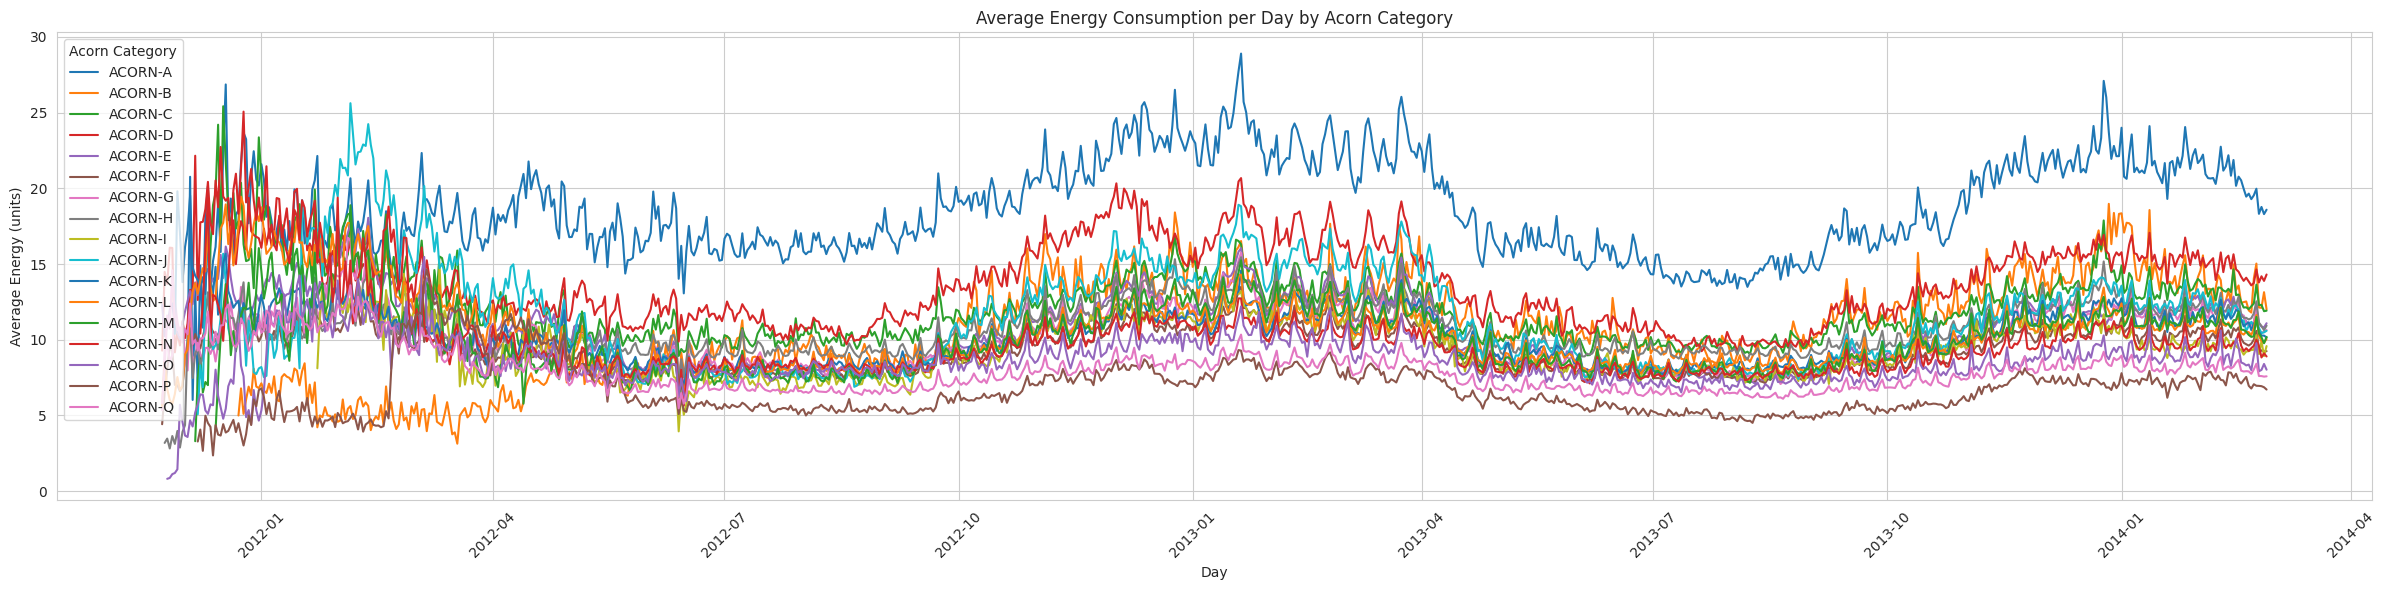

In [ ]:
# plotting the energy consumption every day by acorn type

sns.set_style("whitegrid")

plt.figure(figsize=(24, 6))

# Loop every  unique Acorn value

unique_acorns = sorted(grouped_data['Acorn'].unique())

for acorn in unique_acorns:
    acorn_df =  grouped_data[ grouped_data['Acorn'] == acorn]
    plt.plot(acorn_df['day'], acorn_df['avg_energy'], label=acorn)

# set plot style
plt.title('Average Energy Consumption per Day by Acorn Category')
plt.xlabel('Day')
plt.ylabel('Average Energy (units)')
plt.xticks(rotation=45)
plt.legend(title='Acorn Category')
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# Calculates the avg energy
avg_energy_per_acorn = grouped_data.groupby('Acorn')['avg_energy'].mean().reset_index()

# Renaming the column to 'avg_energy_day' to reflect that it's an average per day per Acorn
avg_energy_per_acorn.rename(columns={'avg_energy': 'avg_energy_day'}, inplace=True)

avg_energy_per_acorn

Acorn  avg_energy_day
0   ACORN-A       18.710652
1   ACORN-B       10.731516
2   ACORN-C       12.235217
3   ACORN-D       13.770427
4   ACORN-E       10.744679
5   ACORN-F        9.307645
6   ACORN-G       10.192191
7   ACORN-H       10.760731
8   ACORN-I        9.426731
9   ACORN-J       11.573594
10  ACORN-K       10.295890
11  ACORN-L       10.506535
12  ACORN-M       10.079187
13  ACORN-N        9.862940
14  ACORN-O        8.588455
15  ACORN-P        6.691987
16  ACORN-Q        7.983495

####2.3.2 Determining the energy usage by ward

In [ ]:

"""

The income df is used as weights to determine how each acorn affects the electricity usage of each income bracket

Calculated by taking the distribution of each acorn in 5 income brackets (from the acorn details csv) and
-> dividing it by 100
-> multiplying it by the percentage of the population the income bracket makes up
-> the total resulting distribution causes the sum of all income bracket distribution to exceed 1 in almost all acorns
( this is caused by the lack of precise data regarding the income distribution)
-> to fix this issue, we multiply each entry again by ( 1/ sum_of percentage of all income bracket distribution for the corresponding acorn)
-> Finaly the values as weights are multiplied by the number of occurence of the acorns in the data (to generate an accurate distribution of power usage according to our data)

* this process was done using excel
"""

income = pd.read_csv('/content/drive/MyDrive/DSDataset/acorn_income.csv')
income.head()

ACORN-A   ACORN-B    ACORN-C    ACORN-D     ACORN-E     ACORN-F  \
0  11.315315  2.831524  36.436195  47.070291  320.688372  197.052632   
1  21.886202  4.884379  42.462181  64.858482  415.437209  210.315789   
2  33.350403  5.993393  34.474246  68.416120  381.910698  150.315789   
3  29.777146  4.459651  18.778654  46.522962  221.566512   71.368421   
4  22.630631  2.914110   9.669606  28.597938  116.613953   31.578947   

     ACORN-G     ACORN-H    ACORN-I    ACORN-J    ACORN-K     ACORN-L  \
0  45.788739  122.791128  23.924799  29.063948  68.874773  137.980918   
1  57.808283  137.509242  15.615040  33.631140  53.003630  111.876420   
2  49.604467  104.288355   7.305282  26.572753  28.148820   60.288960   
3  27.091671   50.882625   2.648165  12.974977   9.882033   21.442980   
4  13.355049   22.707948   0.958818   5.708990   3.294011    6.992276   

     ACORN-M     ACORN-N    ACORN-O    ACORN-P     ACORN-Q  
0  52.294170  112.080808  49.425246  59.991147  610.730721  
1  35.572197   29.171717  32.919427  32.722444  172.293300  
2  17.026009    8.444444  14.569382  12.465693   39.221239  
3   5.573991    1.791246   4.333930   3.408588    7.003793  
4   1.722870    0.383838   1.244852   0.973882    1.400759

In [ ]:
# multiplying the income distribution with the avg_energy_day generated by each acorn
income_m = income.mul(avg_energy_per_acorn['avg_energy_day'].tolist())

In [ ]:
# Generating the final electricity usage by dividing income_m by the income weights
row_sums = income_m.sum(axis=1)
row_sums_2 = income.sum(axis=1)
row_sums_x = row_sums/row_sums_2
row_sums_x

0     9.572407
1    10.289505
2    10.800938
3    11.187916
4    11.546630
5    12.210647
dtype: float64

In [ ]:
# Reading a data frame containing the median income in each of the wards in the greater london area
Ward_HI = pd.read_csv('/content/drive/MyDrive/DSDataset/Ward_HI.csv')
Ward_HI.head()

NAME  Mean_HI
0  City of London    99390
1           Abbey    38870
2          Alibon    37290
3       Becontree    37860
4  Chadwell Heath    38860

In [ ]:
# assigning each income bracket with their power values

def return_power(value):
    if value < 20000:
        return  9.572407
    elif 20000 <= value < 40000:
        return 10.289505
    elif 40000 <= value < 60000:
        return  10.800938
    elif 60000 <= value < 80000:
        return 11.187916
    elif 80000 <= value < 100000:
        return 11.546630
    else:
        return 12.210647

Ward_HI['Energy_Use'] = Ward_HI['Mean_HI'].apply(return_power)

In [ ]:
# Load the shapefile of the London wards
shp_file_path = "/content/drive/MyDrive/DSDataset/London_Ward_CityMerged.shp"
wards_shapefile = gpd.read_file(shp_file_path)

In [ ]:
wards_shapefile

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
0         Chessington South  E05000405   755.173       0.000  E09000021   
1    Tolworth and Hook Rise  E05000414   259.464       0.000  E09000021   
2                Berrylands  E05000401   145.390       0.000  E09000021   
3                 Alexandra  E05000400   268.506       0.000  E09000021   
4                  Beverley  E05000402   187.821       0.000  E09000021   
..                      ...        ...       ...         ...        ...   
620               Whalebone  E05000042   155.399       0.000  E09000002   
621               Eastbrook  E05000030   345.060       0.000  E09000002   
622          Chadwell Heath  E05000029   338.422       0.000  E09000002   
623                Parsloes  E05000037   124.384       0.000  E09000002   
624          City of London  E09000001   314.943      24.546  E09000001   

                  BOROUGH  POLY_ID  \
0    Kingston upon Thames    50840   
1    Kingston upon Thames   117160   
2    Kingston upon Thames    50449   
3    Kingston upon Thames    50456   
4    Kingston upon Thames   117161   
..                    ...      ...   
620  Barking and Dagenham   117022   
621  Barking and Dagenham    50856   
622  Barking and Dagenham   117014   
623  Barking and Dagenham   117017   
624        City of London   122502   

                                              geometry  
0    POLYGON ((516401.600 160201.800, 516407.300 16...  
1    POLYGON ((517829.600 165447.100, 517837.100 16...  
2    POLYGON ((518107.500 167303.400, 518114.300 16...  
3    POLYGON ((520480.000 166909.800, 520490.700 16...  
4    POLYGON ((522071.000 168144.900, 522063.900 16...  
..                                                 ...  
620  POLYGON ((549410.700 187450.700, 549391.200 18...  
621  POLYGON ((549991.500 184928.500, 549988.900 18...  
622  POLYGON ((547715.200 187914.200, 547712.500 18...  
623  POLYGON ((547381.600 185753.600, 547377.500 18...  
624  POLYGON ((531361.300 180691.000, 531313.200 18...  

[625 rows x 8 columns]

In [ ]:
# sorting the Ward_HI and wards_shapefile alphabetically
Ward_HI = Ward_HI.sort_values(by='NAME', ascending=True)
wards_shapefile = wards_shapefile.sort_values(by='NAME', ascending=True)

In [ ]:
# Checking if there are any inconsistencies in naming in each df

name_1 = Ward_HI['NAME'].tolist()
name_2 = wards_shapefile ['NAME'].tolist()

for i in name_1:
  if i not in name_2:
    print(i)

print("\n.........................\n")
for i in name_2:
  if i not in name_1:
    print(i)

Roehampton
St Andrew's
St Ann's
St Charles
St Dunstan's and Stepney Green
St George's
St Helier
St Helier
St James
St James's
St Katharine's and Wapping
St Leonard's
St Margarets and North Twickenham
St Mark's
St Mary's
St Mary's
St Mary's Park
St Michael's
St Pancras and Somers Town
St Peter's

.........................

Roehampton and Putney Heath
St. Andrew's
St. Ann's
St. Charles
St. Dunstan's and Stepney Green
St. George's
St. Helier
St. Helier
St. James
St. James's
St. Katharine's and Wapping
St. Leonard's
St. Margarets and North Twickenham
St. Mark's
St. Mary's
St. Mary's
St. Mary's Park
St. Michael's
St. Pancras and Somers Town
St. Peter's


In [ ]:
# Correcting the inconsistencies by changing the names in Ward_HI into the ones in wards_shapefile

name_mapping = {
    'Roehampton': 'Roehampton and Putney Heath',
    'St Andrew\'s': 'St. Andrew\'s',
    'St Ann\'s': 'St. Ann\'s',
    'St Charles': 'St. Charles',
    'St Dunstan\'s and Stepney Green': 'St. Dunstan\'s and Stepney Green',
    'St George\'s': 'St. George\'s',
    'St Helier': 'St. Helier',
    'St James': 'St. James',
    'St James\'s': 'St. James\'s',
    'St Katharine\'s and Wapping': 'St. Katharine\'s and Wapping',
    'St Leonard\'s': 'St. Leonard\'s',
    'St Margarets and North Twickenham': 'St. Margarets and North Twickenham',
    'St Mark\'s': 'St. Mark\'s',
    'St Mary\'s': 'St. Mary\'s',
    'St Mary\'s Park': 'St. Mary\'s Park',
    'St Michael\'s': 'St. Michael\'s',
    'St Pancras and Somers Town': 'St. Pancras and Somers Town',
    'St Peter\'s': 'St. Peter\'s'
}

# Replace the values in the DataFrame
Ward_HI['NAME'] = Ward_HI['NAME'].replace(name_mapping)

In [ ]:
# Checkin for any consistencies again

name_1 = Ward_HI['NAME'].tolist()

for i in name_1:
  if i not in name_2:
    print(i)

print("\n.........................\n")
for i in name_2:
  if i not in name_1:
    print(i)


.........................



In [ ]:
#Appending the energy use collumn from wards_shapefile into Ward_HI
wards_shapefile['Energy_Use'] = Ward_HI['Energy_Use']

In [ ]:
wards_shapefile

NAME   GSS_CODE  HECTARES  NONLD_AREA  LB_GSS_CD  \
611                    Abbey  E05000026   128.292       2.655  E09000002   
415                    Abbey  E05000455   139.326       0.000  E09000024   
488               Abbey Road  E05000630   109.492       0.000  E09000033   
284               Abbey Wood  E05000214   265.721       0.000  E09000011   
468                 Abingdon  E05000382    63.060       0.000  E09000020   
..                       ...        ...       ...         ...        ...   
273       Woolwich Riverside  E05000230   326.109      72.317  E09000011   
375           Worcester Park  E05000572   195.703       0.000  E09000029   
453  Wormholt and White City  E05000265    90.164       0.000  E09000013   
143                  Yeading  E05000344   232.126       0.000  E09000017   
126                 Yiewsley  E05000345   402.251       0.000  E09000017   

                    BOROUGH  POLY_ID  \
611    Barking and Dagenham    51353   
415                  Merton    50779   
488             Westminster   117484   
284               Greenwich   117381   
468  Kensington and Chelsea    50660   
..                      ...      ...   
273               Greenwich   117378   
375                  Sutton    50827   
453  Hammersmith and Fulham   117157   
143              Hillingdon    51090   
126              Hillingdon   116722   

                                              geometry  Energy_Use  
611  POLYGON ((543595.500 184832.800, 543601.700 18...   11.187916  
415  POLYGON ((525122.600 170480.900, 525185.400 17...   10.800938  
488  POLYGON ((527370.800 183470.700, 527336.900 18...   10.800938  
284  POLYGON ((546122.300 179468.500, 546212.900 17...   10.800938  
468  POLYGON ((525669.000 178860.700, 525604.000 17...   10.289505  
..                                                 ...         ...  
273  POLYGON ((541392.400 178495.600, 541324.800 17...   11.187916  
375  POLYGON ((524104.000 166073.000, 524060.300 16...   10.800938  
453  POLYGON ((523039.800 180689.300, 523004.100 18...   10.289505  
143  POLYGON ((511031.800 180894.700, 511047.900 18...   10.289505  
126  POLYGON ((505195.600 180097.800, 505194.500 18...   10.800938  

[625 rows x 9 columns]

####2.3.3 Visualizing Data

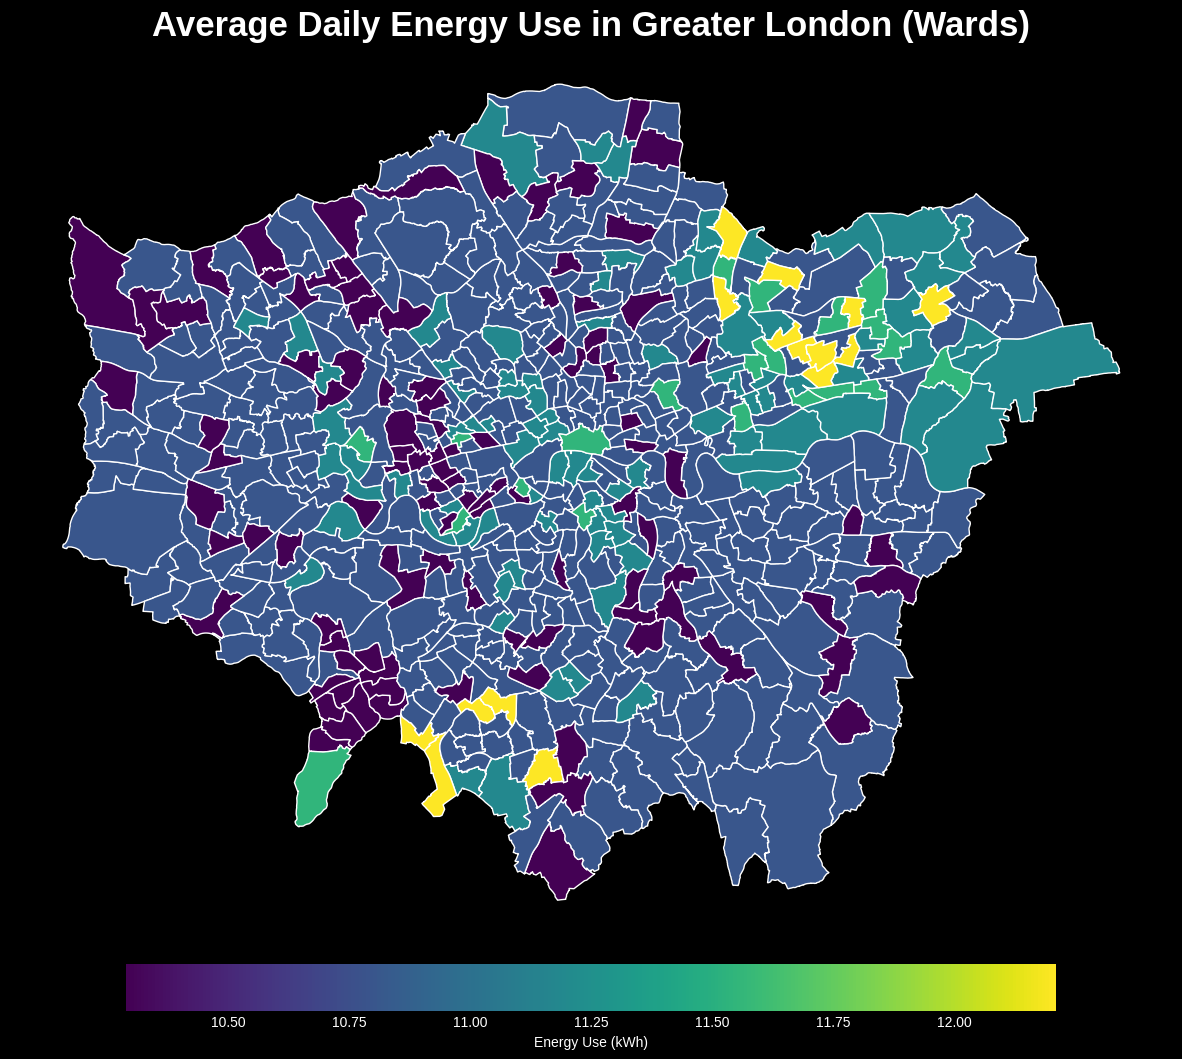

In [ ]:
#plot the figure using matplot lib
fig, ax = plt.subplots(figsize=(15, 15))
wards_shapefile.plot(
    # displayy distribution according to energy use
    column="Energy_Use",
    ax=ax,
    #use the viridis colour scheme
    cmap='viridis',
)

#creates the distribution bar
cbar = plt.cm.ScalarMappable(cmap='viridis')
cbar.set_array(wards_shapefile['Energy_Use'])
cbar.set_clim(vmin=min(wards_shapefile['Energy_Use']), vmax=max(wards_shapefile['Energy_Use']))
plt.colorbar(cbar, ax=ax, orientation='horizontal', label='Energy Use (kWh)', shrink=0.8, pad=0.02)\

# disables the inner and bounding grids
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# settings for the title
title_font = {'weight': 'bold', 'size': 25}
plt.title('Average Daily Energy Use in Greater London (Wards)', fontdict=title_font)


# code below causes an error but still works
# plt.style('dark_background')

plt.show()

## 3. Data Preprocessing

In [ ]:
X = weather_energy[['temperatureMax', 'humidity', 'windSpeed']]
y = weather_energy['avg_energy']
days = weather_energy['day']

### 3.1 Normalization

Rescaling the data from the original range so that all values are within the new range of 0 and 1.

In [ ]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## 4. Model Training

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(3, 50),          # Maximum depth of trees
}

In [ ]:
# Split the data into train and test
train_ratio = int(len(X) * 0.8)
X_train = X[:train_ratio]
y_train = y[:train_ratio]

X_test = X[train_ratio:len(X)]
y_test = y[train_ratio:len(X)]

In [ ]:
# Define the regressor
rf_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state = 42)

# Fit the training data into the model
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, n_iter=150, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782ea40f4130>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782ea40f6a40>},
                   random_state=42, verbose=2)

In [ ]:
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 4, 'n_estimators': 996}


In [ ]:
best_rf = RandomForestRegressor(**best_params, random_state = 42)

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

In [ ]:
print("Used Hyperparameters:")
print("n_estimators:", rf_regressor.n_estimators)
print("max_depth:", rf_regressor.max_depth)
print("min_samples_split:", rf_regressor.min_samples_split)
print("min_samples_leaf:", rf_regressor.min_samples_leaf)
print("max_features:", rf_regressor.max_features)
print("bootstrap:", rf_regressor.bootstrap)
print("random_state:", rf_regressor.random_state)

Used Hyperparameters:
n_estimators: 100
max_depth: None
min_samples_split: 2
min_samples_leaf: 1
max_features: 1.0
bootstrap: True
random_state: 42


In [ ]:
print("Used Hyperparameters:")
print("n_estimators:", best_rf.n_estimators)
print("max_depth:", best_rf.max_depth)
print("min_samples_split:", best_rf.min_samples_split)
print("min_samples_leaf:", best_rf.min_samples_leaf)
print("max_features:", best_rf.max_features)
print("bootstrap:", best_rf.bootstrap)
print("random_state:", best_rf.random_state)

Used Hyperparameters:
n_estimators: 996
max_depth: 4
min_samples_split: 2
min_samples_leaf: 1
max_features: 1.0
bootstrap: True
random_state: 42


## 5. Model Evaluation

In [ ]:
print("R2 Score: {}".format(r2_score(y_test, y_pred)))
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(y_test, y_pred))))

R2 Score: 0.6319921760700076
Root Mean Squared Error: 0.6610381960078079


In [ ]:
# Store the result in a Dataframe
result = pd.DataFrame()
result['Prediction'] = y_pred
result['Actual'] = y_test.values.ravel()
result['Diff'] = np.abs(y_test.values.ravel() - y_pred)

In [ ]:
print('Maximum diff :', max(result.Diff))
print('Minimum diff :', min(result.Diff))

Maximum diff : 2.905188727656407
Minimum diff : 0.01572482430490929


In [ ]:
test_days = days[train_ratio:len(X)]

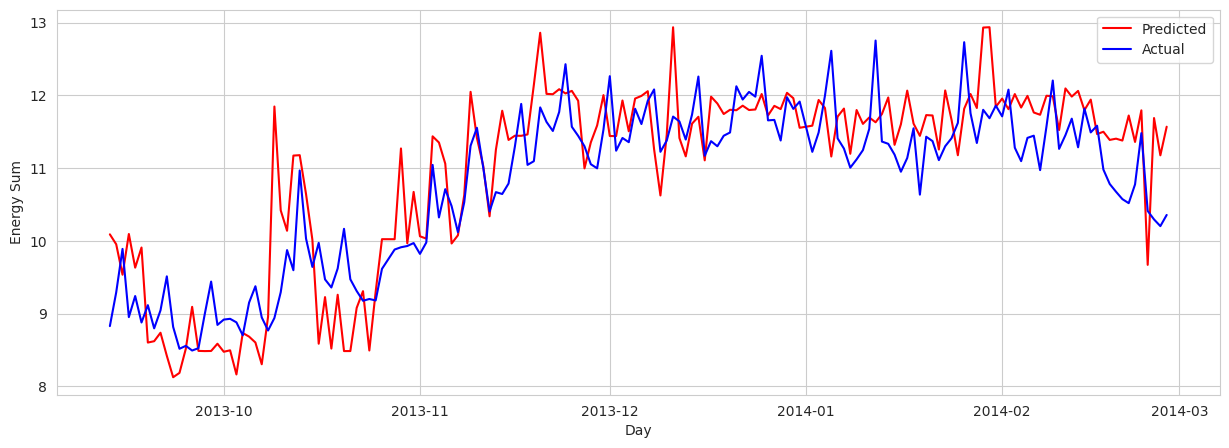

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_days, result['Prediction'], color='r', label='Predicted')
plt.plot(test_days, result['Actual'], color='b', label='Actual')
plt.xlabel('Day')
plt.ylabel('Energy Sum')
plt.legend(loc='upper right')
plt.show()

# 6. Model 2

The focus for this model is to predict the average energy consumption not only through weather variables, but also how it's measured and what household group they are. We also consider the day, because there will be holidays on some certain days.

### 6.1 Data Preparation

#### 6.1.1 Grouping Data

We first prepare data by merging data from other tables into a single table, so it's easier for us to model with and the data will align with one another.

In [ ]:
households

LCLid stdorToU    Acorn Acorn_grouped       file
2     MAC000002      Std  ACORN-A      Affluent    block_0
3     MAC003613      Std  ACORN-A      Affluent    block_0
4     MAC003597      Std  ACORN-A      Affluent    block_0
5     MAC003579      Std  ACORN-A      Affluent    block_0
6     MAC003566      Std  ACORN-A      Affluent    block_0
...         ...      ...      ...           ...        ...
5561  MAC002056      Std  ACORN-U       ACORN-U  block_111
5562  MAC004587      Std  ACORN-U       ACORN-U  block_111
5563  MAC004828      Std  ACORN-U       ACORN-U  block_111
5564  MAC001704      ToU  ACORN-U       ACORN-U  block_111
5565  MAC002774      ToU  ACORN-U       ACORN-U  block_111

[5564 rows x 5 columns]

In [ ]:
daily_energy_consumptions_with_acorn_grouped = pd.merge(daily_energy_consumptions, households[['LCLid', 'Acorn_grouped', 'stdorToU']], on='LCLid', how='left')
daily_energy_consumptions_with_acorn_grouped

LCLid         day  energy_median  energy_mean  energy_max  \
0        MAC000131  2011-12-15         0.4850     0.432045       0.868   
1        MAC000131  2011-12-16         0.1415     0.296167       1.116   
2        MAC000131  2011-12-17         0.1015     0.189812       0.685   
3        MAC000131  2011-12-18         0.1140     0.218979       0.676   
4        MAC000131  2011-12-19         0.1910     0.325979       0.788   
...            ...         ...            ...          ...         ...   
3505441  MAC004977  2014-02-23         0.1365     0.174646       0.754   
3505442  MAC004977  2014-02-24         0.0950     0.118458       0.580   
3505443  MAC004977  2014-02-25         0.0675     0.084208       0.176   
3505444  MAC004977  2014-02-26         0.1080     0.120500       0.282   
3505445  MAC004977  2014-02-27         0.0720     0.114062       0.431   

         energy_count  energy_std  energy_sum  energy_min Acorn_grouped  \
0                  22    0.239146       9.505       0.072      Affluent   
1                  48    0.281471      14.216       0.031      Affluent   
2                  48    0.188405       9.111       0.064      Affluent   
3                  48    0.202919      10.511       0.065      Affluent   
4                  48    0.259205      15.647       0.066      Affluent   
...               ...         ...         ...         ...           ...   
3505441            48    0.151583       8.383       0.046      Affluent   
3505442            48    0.093814       5.686       0.052      Affluent   
3505443            48    0.037107       4.042       0.046      Affluent   
3505444            48    0.069332       5.784       0.046      Affluent   
3505445            48    0.094482       5.475       0.047      Affluent   

        stdorToU  
0            Std  
1            Std  
2            Std  
3            Std  
4            Std  
...          ...  
3505441      ToU  
3505442      ToU  
3505443      ToU  
3505444      ToU  
3505445      ToU  

[3505446 rows x 11 columns]

In [ ]:
housecount_per_day_with_acorn_grouped = daily_energy_consumptions_with_acorn_grouped.groupby(['day', 'Acorn_grouped'])[['LCLid']].nunique()
housecount_per_day_with_acorn_grouped

grouped_data = daily_energy_consumptions_with_acorn_grouped.groupby(['day', 'Acorn_grouped', 'stdorToU'])[['energy_sum']].sum().reset_index()
grouped_data = grouped_data.merge(housecount_per_day_with_acorn_grouped, on = ['day', 'Acorn_grouped'])
grouped_data = grouped_data.rename(columns={'LCLid': 'household_num'})

grouped_data = grouped_data.reset_index()

grouped_data.day = pd.to_datetime(grouped_data.day, format='%Y-%m-%d').dt.date

grouped_data['avg_energy'] = grouped_data['energy_sum']/grouped_data['household_num']

print("Starting Point of Data at Day Level  :",min(grouped_data.day))
print("Ending Point of Data at Day Level    :",max(grouped_data.day))

grouped_data

Starting Point of Data at Day Level  : 2011-11-23
Ending Point of Data at Day Level    : 2014-02-27


index         day Acorn_grouped stdorToU    energy_sum  household_num  \
0         0  2011-11-23     Adversity      Std      5.798000              2   
1         1  2011-11-23     Adversity      ToU      5.619000              2   
2         2  2011-11-23      Affluent      Std     46.206000              4   
3         3  2011-11-23   Comfortable      Std     29.726000              7   
4         4  2011-11-23   Comfortable      ToU      3.036000              7   
...     ...         ...           ...      ...           ...            ...   
6580   6580  2014-02-27     Adversity      ToU   2258.741001           1646   
6581   6581  2014-02-27      Affluent      Std  18305.561000           1922   
6582   6582  2014-02-27      Affluent      ToU   4976.988999           1922   
6583   6583  2014-02-27   Comfortable      Std  11164.386000           1378   
6584   6584  2014-02-27   Comfortable      ToU   2696.679000           1378   

      avg_energy  
0       2.899000  
1       2.809500  
2      11.551500  
3       4.246571  
4       0.433714  
...          ...  
6580    1.372261  
6581    9.524225  
6582    2.589484  
6583    8.101877  
6584    1.956951  

[6585 rows x 7 columns]

In [ ]:
weather['day'] = pd.to_datetime(weather.time)
weather['day'] = pd.to_datetime(weather.day, format = '%Y%m%d').dt.date

In [ ]:
fullDf = pd.merge(grouped_data, weather[['day', 'temperatureMax', 'humidity', 'windSpeed']], on='day', how='left')
fullDf.tail()

index         day Acorn_grouped stdorToU    energy_sum  household_num  \
6596   6580  2014-02-27     Adversity      ToU   2258.741001           1646   
6597   6581  2014-02-27      Affluent      Std  18305.561000           1922   
6598   6582  2014-02-27      Affluent      ToU   4976.988999           1922   
6599   6583  2014-02-27   Comfortable      Std  11164.386000           1378   
6600   6584  2014-02-27   Comfortable      ToU   2696.679000           1378   

      avg_energy  temperatureMax  humidity  windSpeed  
6596    1.372261           10.31      0.74       4.14  
6597    9.524225           10.31      0.74       4.14  
6598    2.589484           10.31      0.74       4.14  
6599    8.101877           10.31      0.74       4.14  
6600    1.956951           10.31      0.74       4.14

Removing Outlier

In [ ]:
fullDf['day'] = pd.to_datetime(fullDf['day'])
fullDf = fullDf[fullDf['day'] != '2014-02-28']
fullDf.tail()

index        day Acorn_grouped stdorToU    energy_sum  household_num  \
6596   6580 2014-02-27     Adversity      ToU   2258.741001           1646   
6597   6581 2014-02-27      Affluent      Std  18305.561000           1922   
6598   6582 2014-02-27      Affluent      ToU   4976.988999           1922   
6599   6583 2014-02-27   Comfortable      Std  11164.386000           1378   
6600   6584 2014-02-27   Comfortable      ToU   2696.679000           1378   

      avg_energy  temperatureMax  humidity  windSpeed  
6596    1.372261           10.31      0.74       4.14  
6597    9.524225           10.31      0.74       4.14  
6598    2.589484           10.31      0.74       4.14  
6599    8.101877           10.31      0.74       4.14  
6600    1.956951           10.31      0.74       4.14

In [ ]:
fullDf.dtypes

index                      int64
day               datetime64[ns]
Acorn_grouped             object
stdorToU                  object
energy_sum               float64
household_num              int64
avg_energy               float64
temperatureMax           float64
humidity                 float64
windSpeed                float64
dtype: object

In [ ]:
fullDf.max()

index                            6584
day               2014-02-27 00:00:00
Acorn_grouped             Comfortable
stdorToU                          ToU
energy_sum                  30430.647
household_num                    2182
avg_energy                     21.522
temperatureMax                   32.4
humidity                         0.98
windSpeed                        9.96
dtype: object

#### 6.1.2 Encode Label Data

Because some column are non numerical values, we decided to make it a numerical values so it could be a feature for the random forest regressor. We also remove the Null values.

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
encoder = le.fit(fullDf['Acorn_grouped'])
fullDf['Acorn_grouped'] = encoder.transform(fullDf['Acorn_grouped'])

In [ ]:
touEncoder = le.fit(fullDf['stdorToU'])
fullDf['stdorToU'] = touEncoder.transform(fullDf['stdorToU'])

In [ ]:
fullDf.tail()
fullDf.isna().sum()

index              0
day                0
Acorn_grouped      0
stdorToU           0
energy_sum         0
household_num      0
avg_energy         0
temperatureMax    16
humidity          16
windSpeed         16
dtype: int64

In [ ]:
fullDf = fullDf.dropna()
fullDf.isna().sum()

index             0
day               0
Acorn_grouped     0
stdorToU          0
energy_sum        0
household_num     0
avg_energy        0
temperatureMax    0
humidity          0
windSpeed         0
dtype: int64

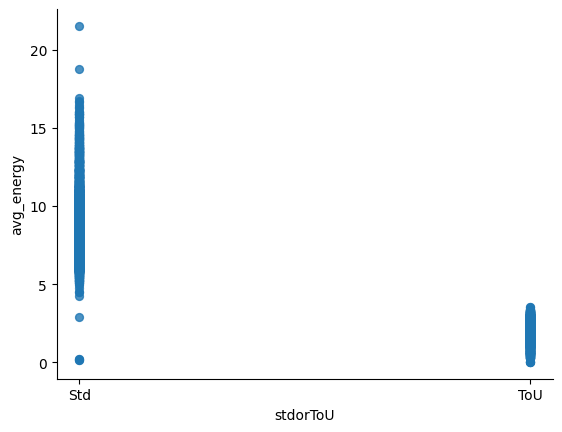

In [ ]:
fullDf.plot(kind='scatter', x='stdorToU', y='avg_energy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

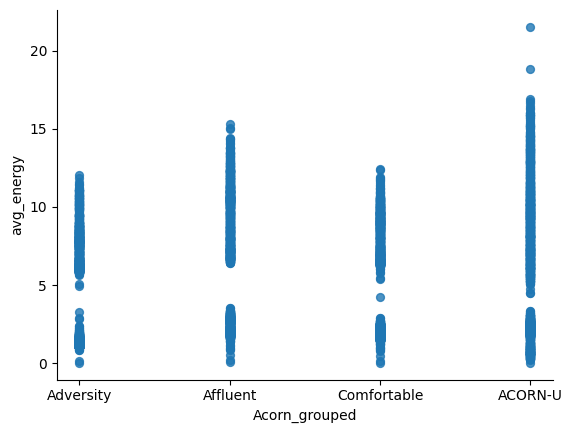

In [ ]:
fullDf.plot(kind='scatter', x='Acorn_grouped', y='avg_energy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

#### 6.1.3 Data Scaling

We also normalize the dataframe for temperature max, humidity, and wind speed

In [ ]:
dfX = fullDf[['Acorn_grouped', 'stdorToU', 'temperatureMax', 'humidity', 'windSpeed']]
dfy = fullDf['avg_energy']

In [ ]:
scaledX = pd.DataFrame(fullDf[['Acorn_grouped', 'stdorToU']])
scaler = MinMaxScaler()
scaledX[['temperatureMax', 'humidity', 'windSpeed']] = scaler.fit_transform(dfX[['temperatureMax', 'humidity', 'windSpeed']])
scaledX

Acorn_grouped  stdorToU  temperatureMax  humidity  windSpeed
0                 1         0         0.32101  0.909091   0.188525
1                 1         1         0.32101  0.909091   0.188525
2                 2         0         0.32101  0.909091   0.188525
3                 3         0         0.32101  0.909091   0.188525
4                 3         1         0.32101  0.909091   0.188525
...             ...       ...             ...       ...        ...
6596              1         1         0.31947  0.563636   0.403689
6597              2         0         0.31947  0.563636   0.403689
6598              2         1         0.31947  0.563636   0.403689
6599              3         0         0.31947  0.563636   0.403689
6600              3         1         0.31947  0.563636   0.403689

[6585 rows x 5 columns]

#### 6.1.4 Split Data

We split data into a train and test

In [ ]:
train_ratio = int(len(scaledX) * 0.8)
Xtrain = scaledX[:train_ratio]
ytrain = dfy[:train_ratio]

Xtest = scaledX[train_ratio:len(scaledX)]
ytest = dfy[train_ratio:len(scaledX)]

### 6.2 Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [ ]:
param_dist = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(3, 50),          # Maximum depth of trees
}

In [ ]:
random_search = RandomizedSearchCV(estimator=rf_regressor, param_distributions=param_dist, n_iter=15, cv=5, verbose=2, random_state=42, n_jobs=-1)

In [ ]:
random_search.fit(Xtrain, ytrain)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782e94551ab0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x782e94551f60>},
                   random_state=42, verbose=2)

In [ ]:
best_params = random_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'max_depth': 13, 'n_estimators': 558}


In [ ]:
best_rf = RandomForestRegressor(**best_params, random_state = 42)

best_rf.fit(Xtrain, ytrain)
best_rf_pred = best_rf.predict(Xtest)

In [ ]:
# Define the regressor
rf_regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state = 42)

# Fit the training data into the model
rf_regressor.fit(Xtrain, ytrain)
pred = rf_regressor.predict(Xtest)

## 7. Model Evaluation

In [ ]:
print("R2 Score: {}".format(r2_score(ytest, pred)))
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(ytest, pred))))

R2 Score: 0.9371938103175366
Root Mean Squared Error: 0.8828514149058794


In [ ]:
print("R2 Score: {}".format(r2_score(ytest, best_rf_pred)))
print("Root Mean Squared Error: {}".format(np.sqrt(mean_squared_error(ytest, best_rf_pred))))

R2 Score: 0.9398931144319642
Root Mean Squared Error: 0.8636713374231231


In [ ]:
res = pd.DataFrame()
res['Prediction'] = best_rf_pred
res['Actual'] = ytest.values.ravel()
res['Diff'] = np.abs(ytest.values.ravel() - best_rf_pred)

In [ ]:
days = fullDf['day']
test_days = days[train_ratio:len(dfX)]

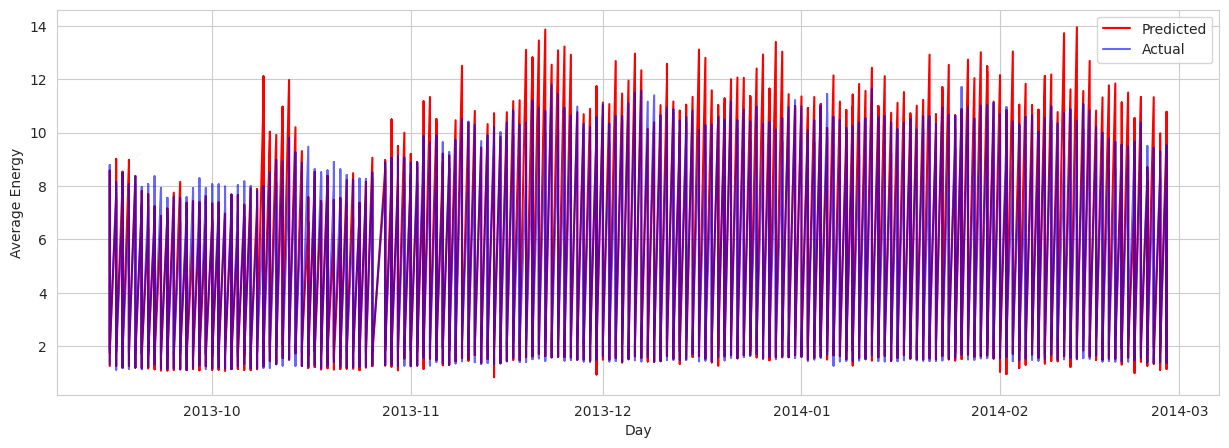

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(test_days, res['Prediction'], color='r', label='Predicted')
plt.plot(test_days, res['Actual'], color='b', label='Actual', alpha = 0.6)
plt.xlabel('Day')
plt.ylabel('Average Energy')
plt.legend(loc='upper right')
plt.show()

In [ ]:
daily_energy_consumptions_with_acorn = pd.merge(daily_energy_consumptions, households[['LCLid', 'Acorn']], on='LCLid', how='left')
daily_energy_consumptions_with_acorn.tail()

In [ ]:
# daily_energy_consumptions_with_acorn.head()


# 	2014-02-28

housecount_per_day_with_acorn = daily_energy_consumptions_with_acorn.groupby(['day', 'Acorn'])[['LCLid']].nunique()

housecount_per_day_with_acorn

grouped_data = daily_energy_consumptions_with_acorn.groupby(['day', 'Acorn'])[['energy_sum']].sum().reset_index()


grouped_data = grouped_data.merge(housecount_per_day_with_acorn, on = ['day', 'Acorn'])
# grouped_data
grouped_data = grouped_data.rename(columns={'LCLid': 'household_num'})

grouped_data = grouped_data.reset_index()

# grouped_data.count()

grouped_data.day = pd.to_datetime(grouped_data.day, format='%Y-%m-%d').dt.date




grouped_data['avg_energy'] = grouped_data['energy_sum']/grouped_data['household_num']

print("Starting Point of Data at Day Level  :",min(grouped_data.day))
print("Ending Point of Data at Day Level    :",max(grouped_data.day))
# grouped_data.head()

# grouped_data.tail(50)

# grouped_data


# daily_energy_consumptions_with_acorn = daily_energy_consumptions_with_acorn.groupby('day')[['energy_sum']].sum()

In [ ]:
import seaborn as sns

sns.set_style("whitegrid")

# Plotting
plt.figure(figsize=(24, 6))

# Loop through each unique Acorn value to plot

unique_acorns = sorted(grouped_data['Acorn'].unique())

for acorn in unique_acorns:
    acorn_df =  grouped_data[ grouped_data['Acorn'] == acorn]
    plt.plot(acorn_df['day'], acorn_df['avg_energy'], label=acorn)

# Configuring plot aesthetics
plt.title('Average Energy Consumption per Day by Acorn Category')
plt.xlabel('Day')
plt.ylabel('Average Energy (units)')
plt.xticks(rotation=45)
plt.legend(title='Acorn Category')
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
avg_energy_per_acorn = grouped_data.groupby('Acorn')['avg_energy'].mean().reset_index()

# Renaming the column to 'avg_energy_day' to reflect that it's an average per day per Acorn
avg_energy_per_acorn.rename(columns={'avg_energy': 'avg_energy_day'}, inplace=True)

avg_energy_per_acorn